In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_quality_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [5]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [6]:
dataframe = (
    load_air_quality_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="6H")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (9357, 14)
set_index: DF Shape (9357, 13)
interpolate_columns: DF Shape (9357, 13)
resample_Data: DF Shape (1560, 13)
dataframe shape (1560, 13)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1560 entries, 2004-03-10 18:00:00 to 2005-04-04 12:00:00
Freq: 6H
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CO_true      1560 non-null   float64
 1   CO_sensor    1560 non-null   float64
 2   NMHC_true    1560 non-null   float64
 3   C6H6_true    1560 non-null   float64
 4   NMHC_sensor  1560 non-null   float64
 5   NOX_true     1560 non-null   float64
 6   NOX_sensor   1560 non-null   float64
 7   NO2_true     1560 non-null   float64
 8   NO2_sensor   1560 non-null   float64
 9   O3_sensor    1560 non-null   float64
 10  T            1560 non-null   float64
 11  RH           1560 non-null   float64
 12  AH           1560 non-null   float64
dtypes: float64(13)
memory usage: 170.6 KB
None

,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,1.966667,1316.500000,86.500000,8.450000,912.333333,132.000000,1167.333333,108.833333,1545.500000,1096.000000,12.033333,54.900000,0.765633
2004-03-11 00:00:00,-32.600000,1083.666667,21.166667,2.216667,595.166667,1.000000,1655.833333,12.500000,1259.333333,575.166667,10.683333,58.900000,0.755017
2004-03-11 06:00:00,1.533333,1215.333333,52.666667,5.600000,778.166667,107.000000,1331.500000,88.833333,1411.333333,810.500000,10.550000,58.666667,0.746217
2004-03-11 12:00:00,2.283333,1313.000000,102.000000,8.716667,923.666667,179.500000,1106.500000,121.166667,1604.166667,917.833333,8.933333,73.816667,0.843533
2004-03-11 18:00:00,4.033333,1364.666667,242.166667,15.383333,1110.833333,232.666667,1015.166667,127.000000,1816.500000,1237.500000,9.183333,64.916667,0.758300


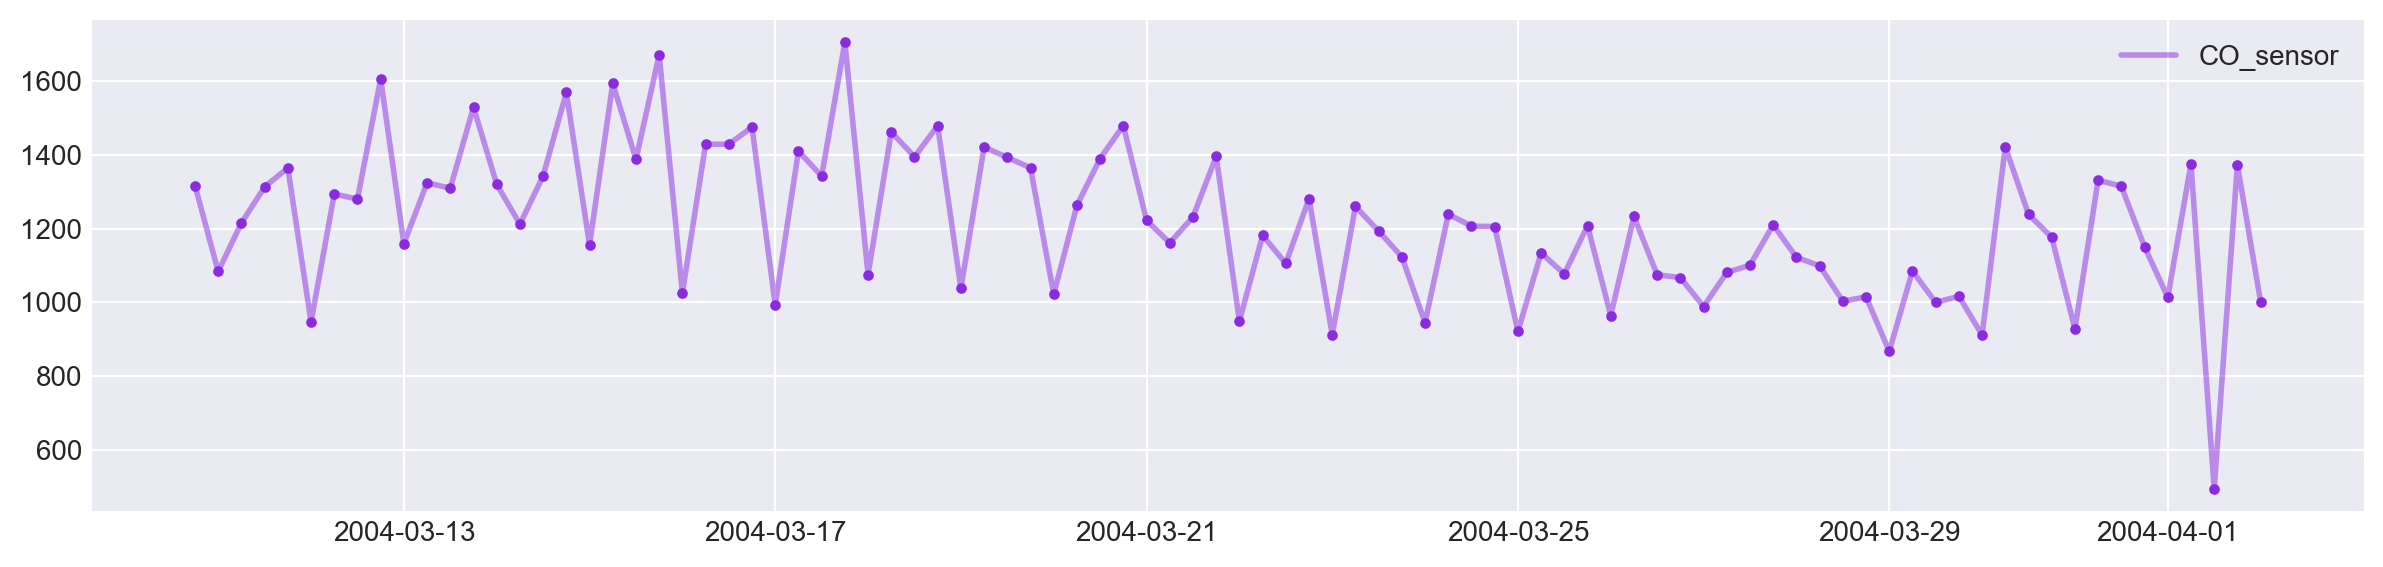

In [7]:
show_dataset(dataframe[:90], columns=["CO_sensor"])

In [10]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "CO_sensor"
TEST_SIZE = 30

In [11]:
print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape (1560, 13)
dataframe shape after Feature Union (1557, 32)

Train Size after Test_Train Split: (1527, 32)
Test  Size after Test_Train Split: (30, 32) 

train_x shape after seperate_target (1527, 31)
train_y shape after seperate_target (1527, 1)
test_x  shape after seperate_target (30, 31)
test_y  shape after seperate_target (30, 1)


In [12]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.882 total time=   0.4s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.835 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.849 total time=   0.2s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.892 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.829 total time=   0.1s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.873 total time=   0.1s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.897 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.820 total time=   0.1s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.896 total time=   0.1s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.893 total time=   0.1s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.810 total time=   0.1s
[CV 3/3] END ..........regressor__n_neighbors=7;,

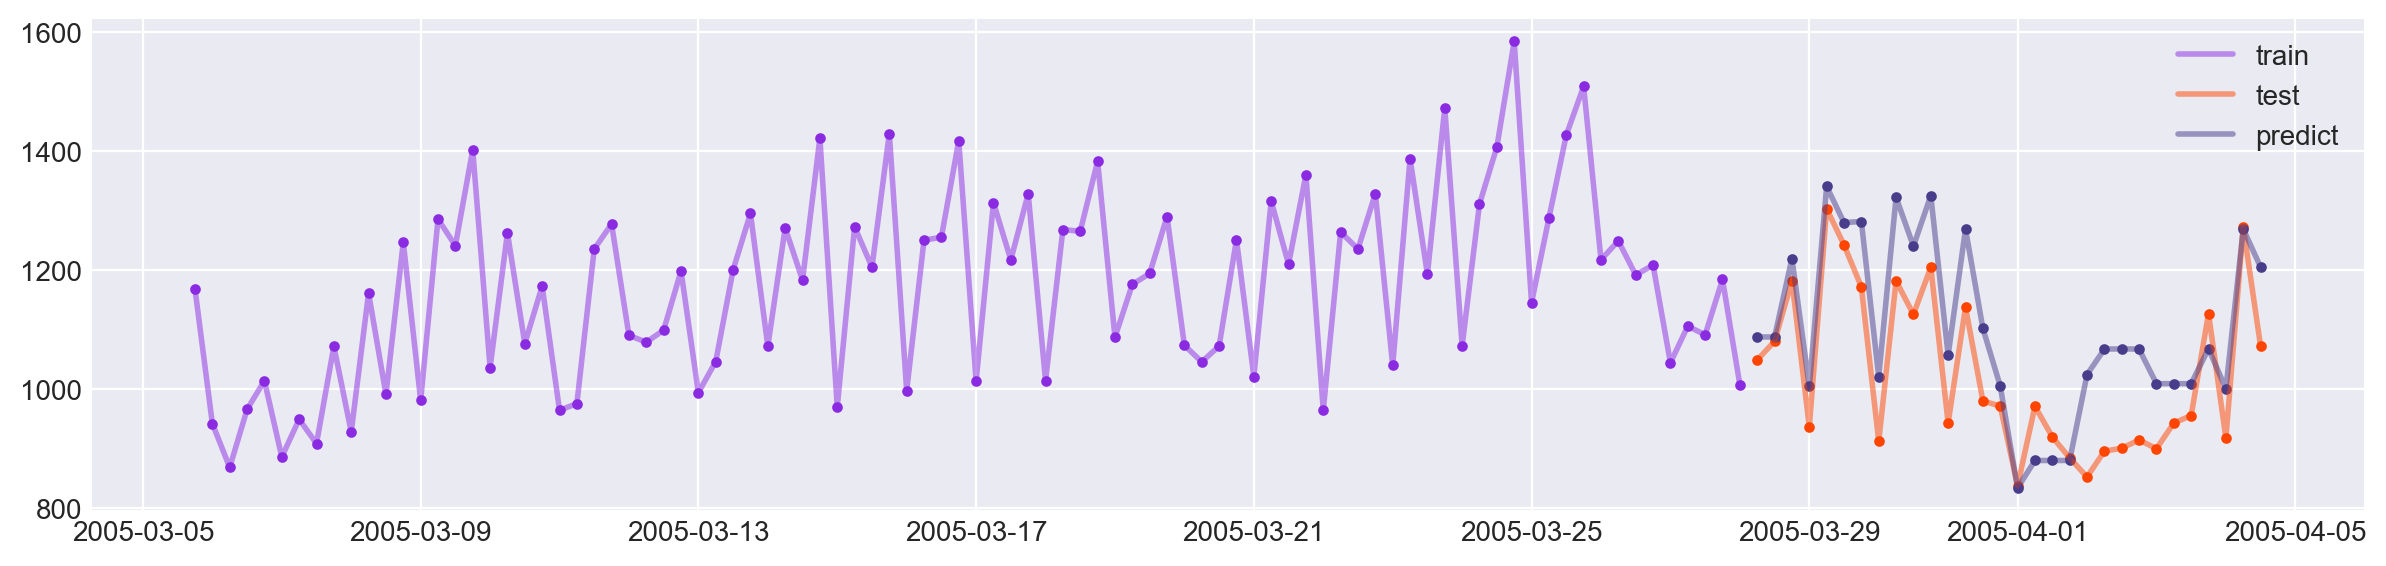

In [14]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [15]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  7  iterations


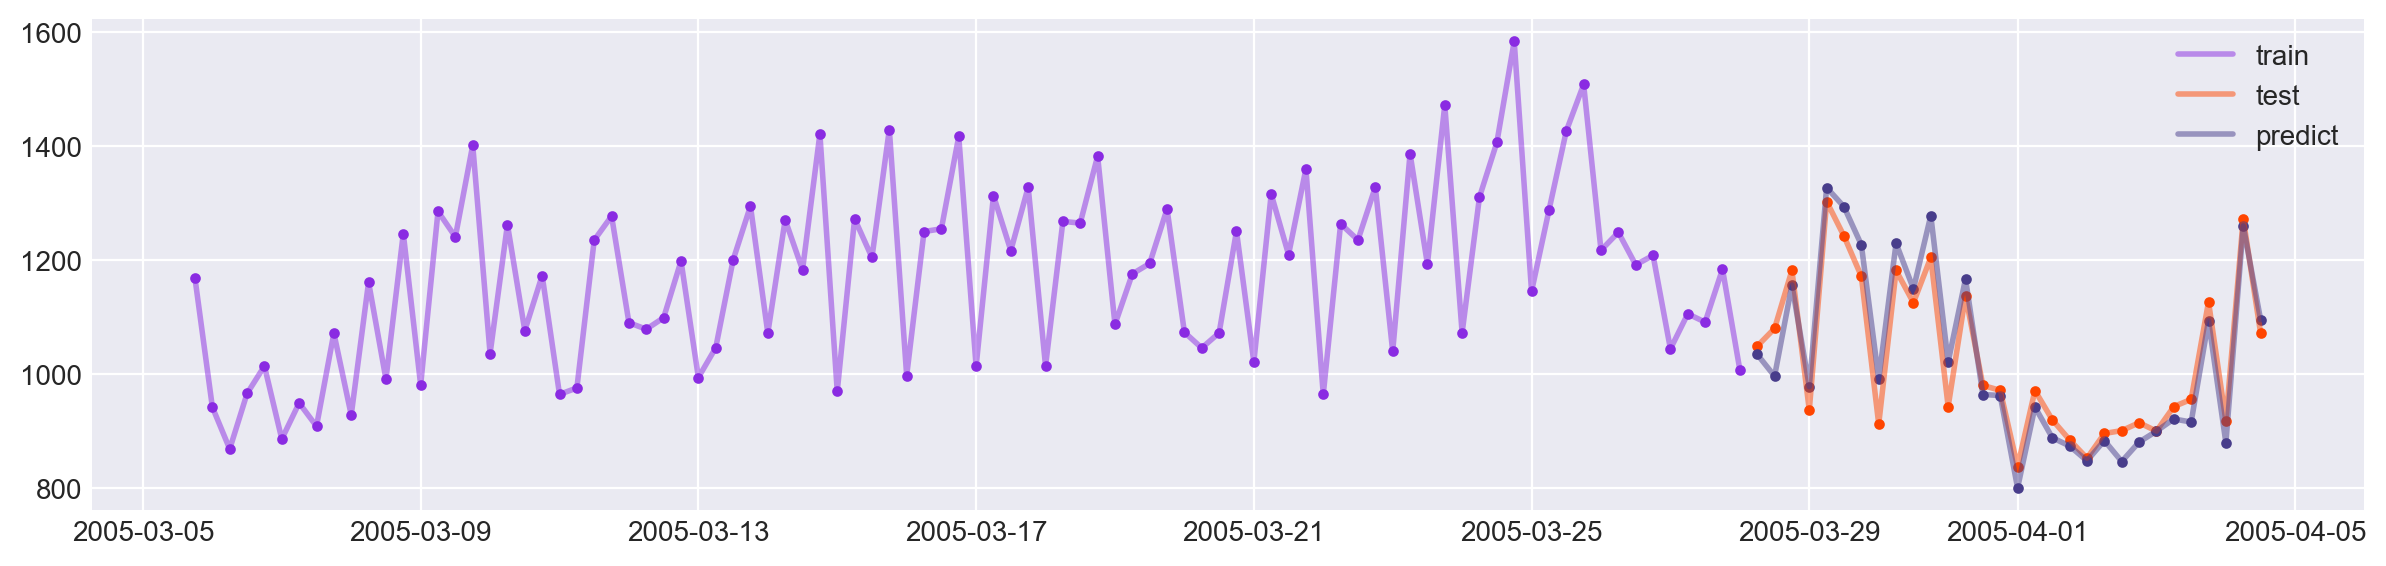

In [16]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [17]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

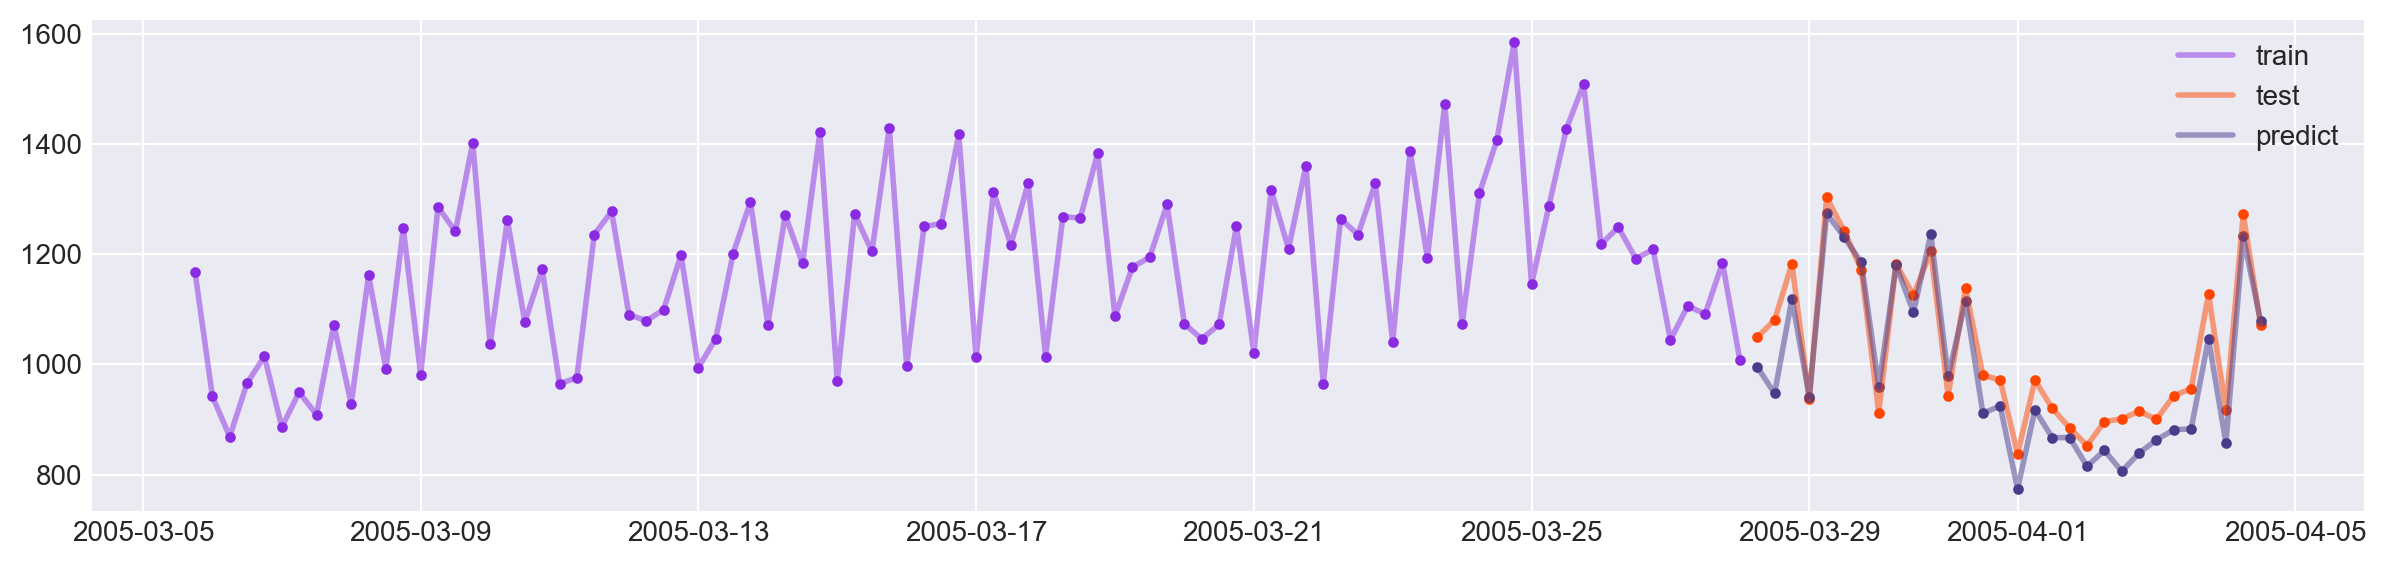

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.951 total time=   6.2s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.941 total time=  13.1s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.958 total time=  20.2s
0.9499344808462342 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 600}


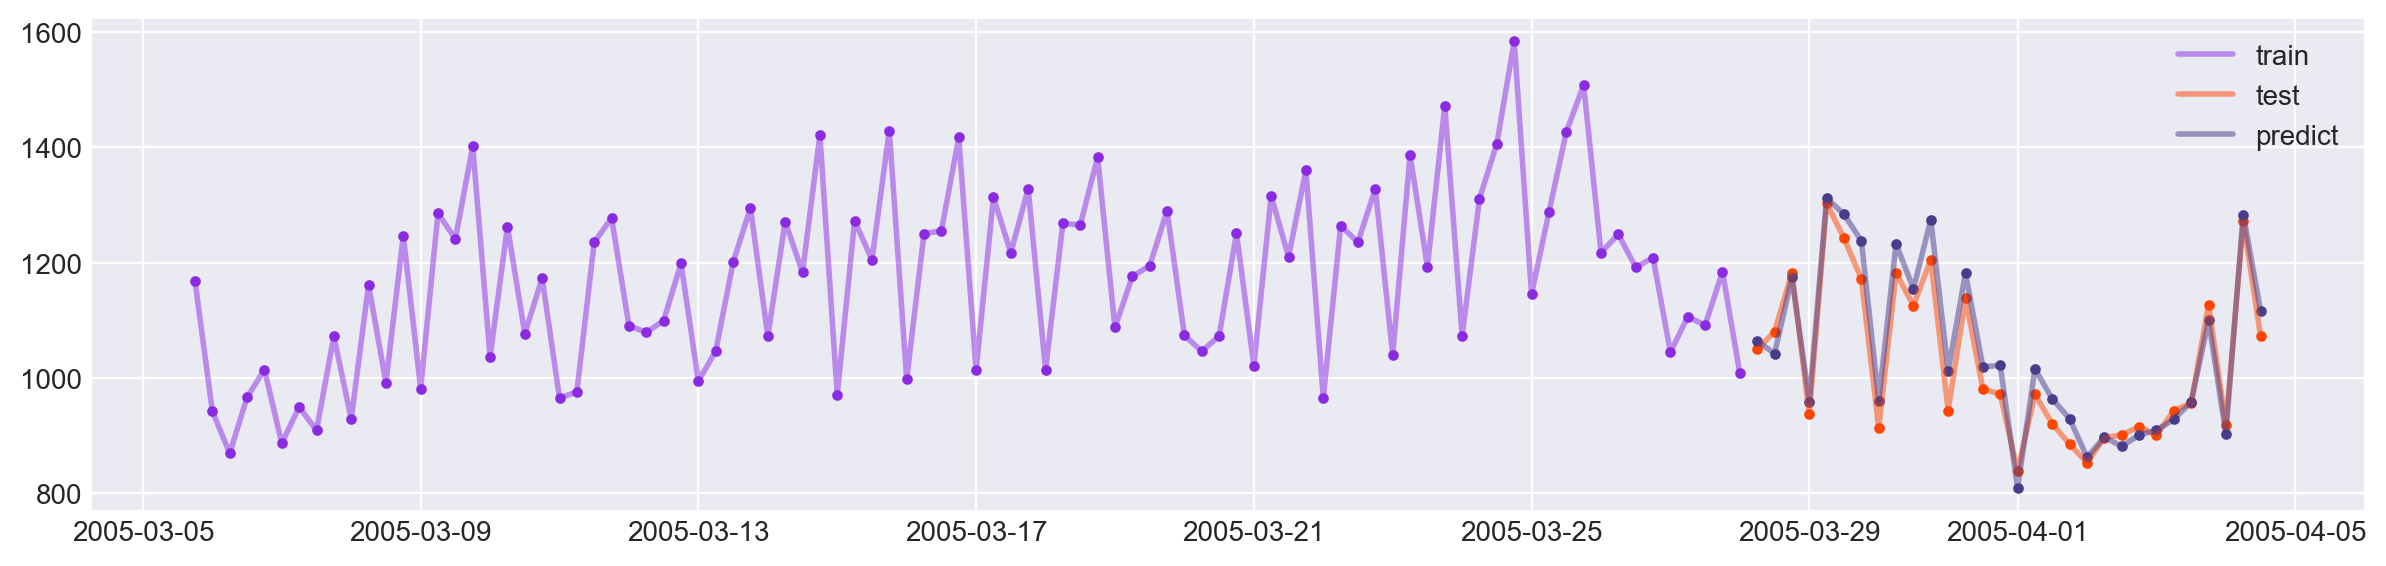

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:1051.45547	validation_1-mae:1015.76414
[1]	validation_0-mae:1040.98318	validation_1-mae:1005.89873
[2]	validation_0-mae:1030.61688	validation_1-mae:996.15987
[3]	validation_0-mae:1020.36107	validation_1-mae:986.45644
[4]	validation_0-mae:1010.20928	validation_1-mae:976.93242
[5]	validation_0-mae:1000.14933	validation_1-mae:967.40663
[6]	validation_0-mae:990.19594	validation_1-mae:957.99025
[7]	validation_0-mae:980.34439	validation_1-mae:948.74883
[8]	validation_0-mae:970.59116	validation_1-mae:939.48778
[9]	validation_0-mae:960.92366	validation_1-mae:930.38198
[10]	validation_0-mae:951.36393	validation_1-mae:921.30604
[11]	validation_0-mae:941.88874	validation_1-mae:912.25617
[12]	validation_0-mae:932.51856	validation_1-mae:903.19560
[13]	validation_0-mae:923.23905	validation_1-mae:894.41251
[14]	validation_0-mae:914.04371	validation_1-mae:885.59448
[15]	validation_0-mae:904.94884	validation_1-mae:876.93544
[16]	validation_0-mae:895.94241	validation_1-mae:868.25899

[139]	validation_0-mae:262.92178	validation_1-mae:250.20530
[140]	validation_0-mae:260.32305	validation_1-mae:247.71229
[141]	validation_0-mae:257.75763	validation_1-mae:245.20294
[142]	validation_0-mae:255.21069	validation_1-mae:242.76290
[143]	validation_0-mae:252.69182	validation_1-mae:240.02444
[144]	validation_0-mae:250.19586	validation_1-mae:237.50303
[145]	validation_0-mae:247.72859	validation_1-mae:235.05625
[146]	validation_0-mae:245.28201	validation_1-mae:232.61500
[147]	validation_0-mae:242.86247	validation_1-mae:230.15192
[148]	validation_0-mae:240.46370	validation_1-mae:227.85256
[149]	validation_0-mae:238.09460	validation_1-mae:225.53590
[150]	validation_0-mae:235.74672	validation_1-mae:223.08714
[151]	validation_0-mae:233.41763	validation_1-mae:220.76811
[152]	validation_0-mae:231.11560	validation_1-mae:218.41735
[153]	validation_0-mae:228.83808	validation_1-mae:216.12112
[154]	validation_0-mae:226.58073	validation_1-mae:213.83130
[155]	validation_0-mae:224.34845	validat

[277]	validation_0-mae:67.72770	validation_1-mae:48.69537
[278]	validation_0-mae:67.08383	validation_1-mae:48.11324
[279]	validation_0-mae:66.44900	validation_1-mae:47.58813
[280]	validation_0-mae:65.81917	validation_1-mae:47.04287
[281]	validation_0-mae:65.19862	validation_1-mae:46.59036
[282]	validation_0-mae:64.58249	validation_1-mae:46.08064
[283]	validation_0-mae:63.97319	validation_1-mae:45.56578
[284]	validation_0-mae:63.37305	validation_1-mae:45.08531
[285]	validation_0-mae:62.77885	validation_1-mae:44.59057
[286]	validation_0-mae:62.19319	validation_1-mae:44.11953
[287]	validation_0-mae:61.61312	validation_1-mae:43.62844
[288]	validation_0-mae:61.03984	validation_1-mae:43.17828
[289]	validation_0-mae:60.46970	validation_1-mae:42.73604
[290]	validation_0-mae:59.91079	validation_1-mae:42.24394
[291]	validation_0-mae:59.35805	validation_1-mae:41.79899
[292]	validation_0-mae:58.81001	validation_1-mae:41.32919
[293]	validation_0-mae:58.26910	validation_1-mae:40.85100
[294]	validati

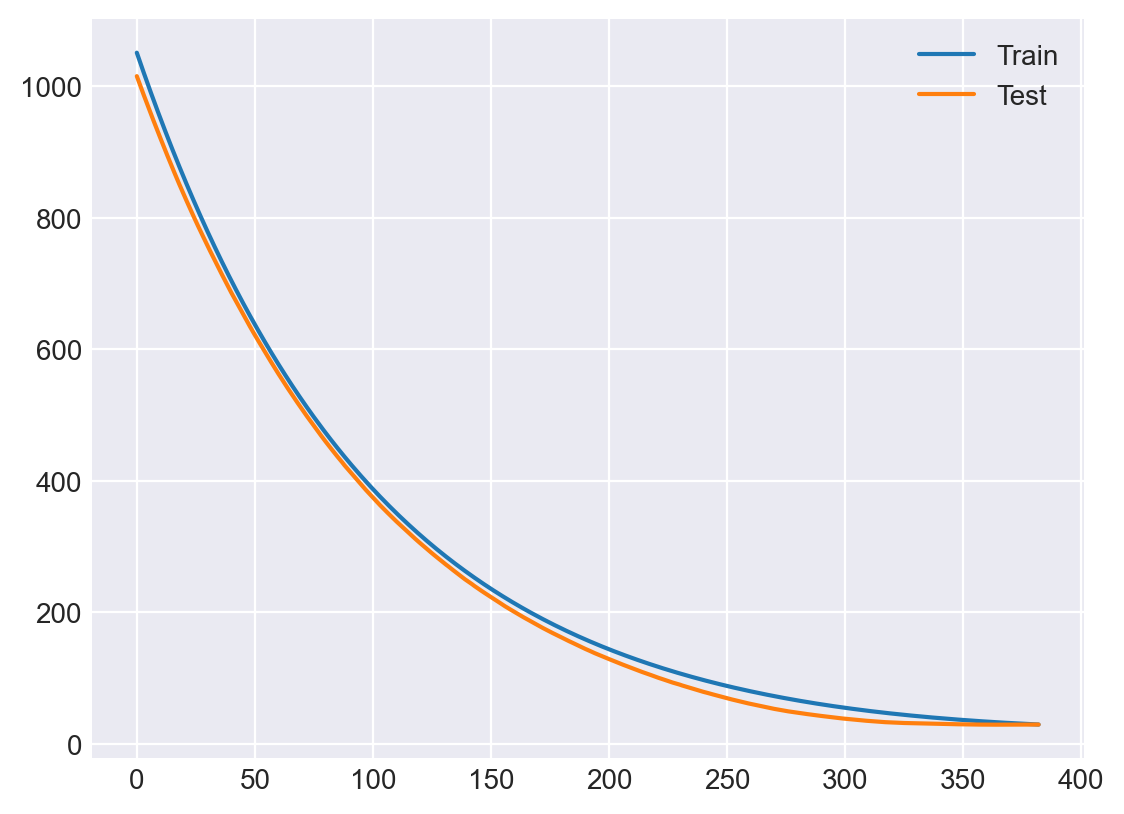

In [21]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

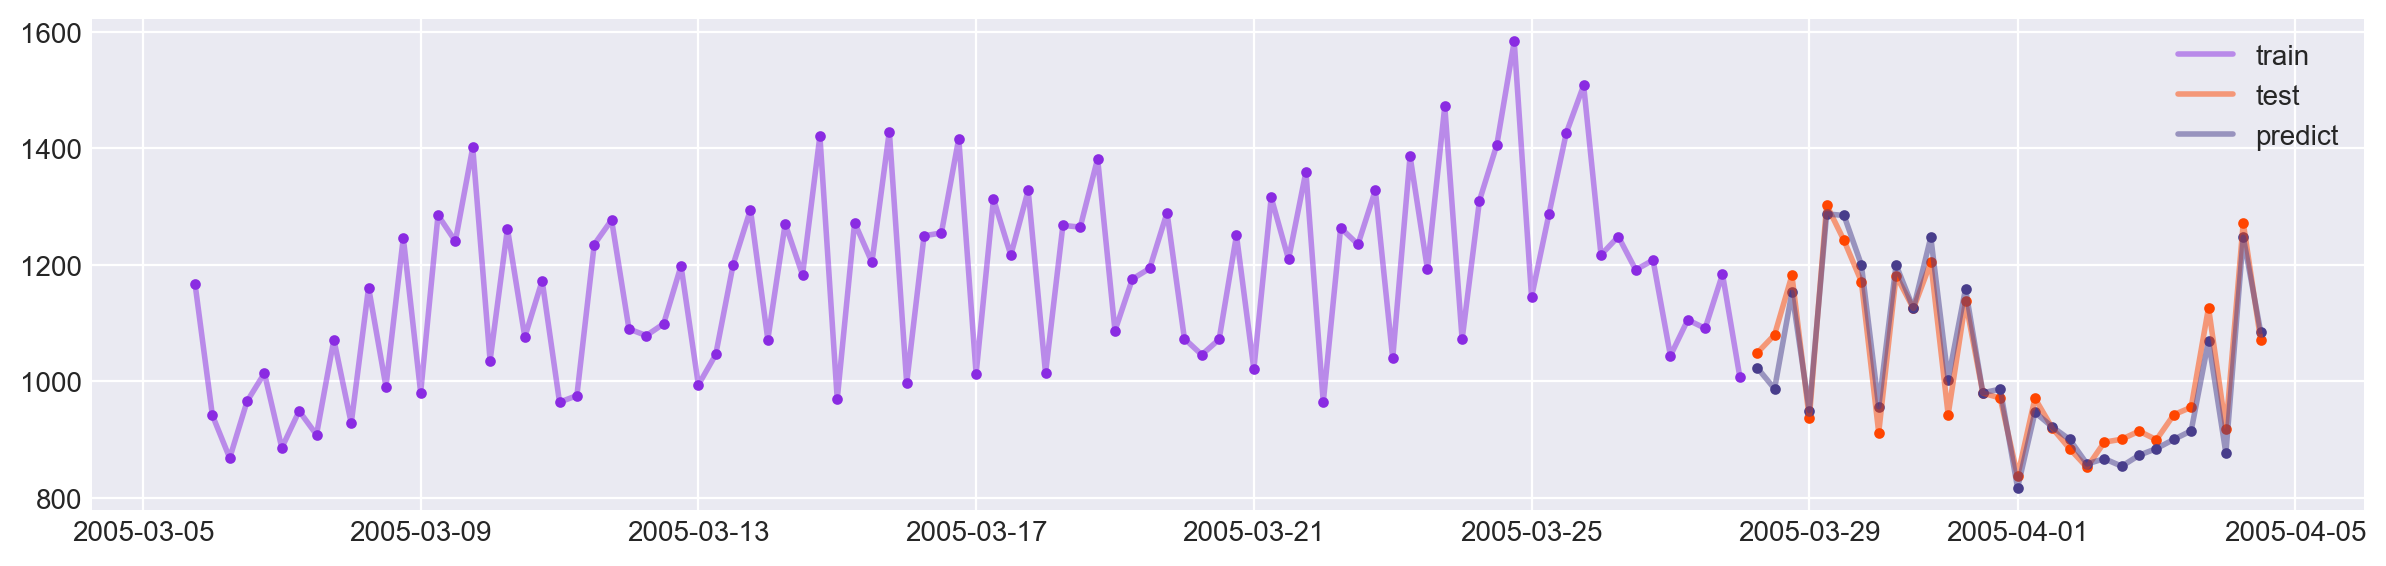

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [23]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 178.526	training's l2: 76839	valid_1's l1: 112.286	valid_1's l2: 15246
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 161.934	training's l2: 62998.5	valid_1's l1: 102.199	valid_1's l2: 12599.6
[3]	training's l1: 147.126	training's l2: 51831.2	valid_1's l1: 90.5496	valid_1's l2: 9920.85
[4]	training's l1: 133.661	training's l2: 42544.9	valid_1's l1: 81.3704	valid_1's l2: 7975.06
[5]	training's l1: 121.727	training's l2: 35027.5	valid_1's l1: 73.1762	valid_1's l2: 6462.99
[6]	training's l1: 110.932	training's l2: 28854.4	valid_1's l1: 65.5321	valid_1's l2: 5267.51
[7]	training's l1: 101.229	training's l2: 23861.6	valid_1's l1: 58.4583	valid_1's l2: 4263.75
[8]	training's l1: 92.4076	training's l2: 19750.4	valid_1's l1: 52.4594	valid_1's l2: 3548.02
[9]	training's l1: 84.684	training's l2: 16366	valid_1's l1: 48.0425	valid_1's l2: 3082.4
[10]	training's l1: 77.7836	training's l2: 13667	valid_1's l1: 42.3093	valid_1's l2: 2549.65
[11]	t

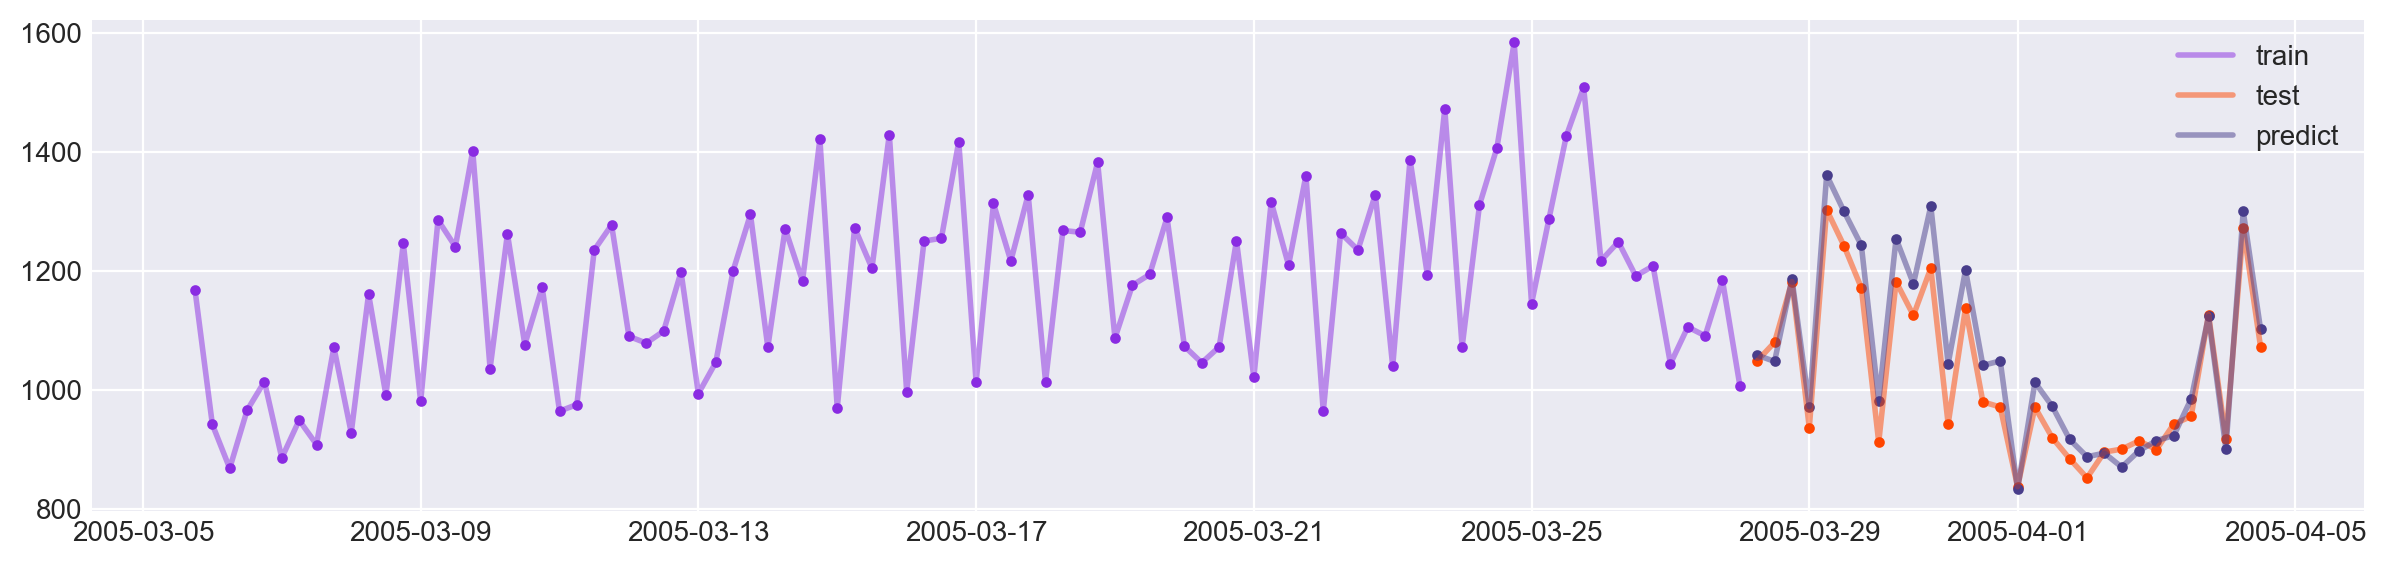

In [24]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [25]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 988.9457226	test: 997.8142567	best: 997.8142567 (0)	total: 164ms	remaining: 2m 44s
1:	learn: 897.5847598	test: 907.2128277	best: 907.2128277 (1)	total: 170ms	remaining: 1m 24s
2:	learn: 817.8353031	test: 826.7909710	best: 826.7909710 (2)	total: 175ms	remaining: 58.3s
3:	learn: 740.9488537	test: 748.5416818	best: 748.5416818 (3)	total: 180ms	remaining: 44.9s
4:	learn: 675.5607220	test: 685.4291596	best: 685.4291596 (4)	total: 186ms	remaining: 37s
5:	learn: 614.1322738	test: 621.9772403	best: 621.9772403 (5)	total: 191ms	remaining: 31.6s
6:	learn: 559.2674534	test: 574.0972343	best: 574.0972343 (6)	total: 196ms	remaining: 27.7s
7:	learn: 507.9989593	test: 526.6644054	best: 526.6644054 (7)	total: 209ms	remaining: 25.9s
8:	learn: 462.8350811	test: 484.1999929	best: 484.1999929 (8)	total: 224ms	remaining: 24.7s
9:	learn: 420.3115996	test: 442.1371305	best: 442.1371305 (9)	total: 233ms	remaining: 23s
10:	learn: 383.3223769	test: 417.0206126	best: 417.0206126 (10)	total: 243ms	remai

96:	learn: 42.4006191	test: 68.9397653	best: 68.9397653 (96)	total: 1.72s	remaining: 16s
97:	learn: 42.1852535	test: 68.9085343	best: 68.9085343 (97)	total: 1.74s	remaining: 16s
98:	learn: 41.9708883	test: 68.8305097	best: 68.8305097 (98)	total: 1.75s	remaining: 16s
99:	learn: 41.7952893	test: 68.4079152	best: 68.4079152 (99)	total: 1.77s	remaining: 15.9s
100:	learn: 41.5446964	test: 68.0070155	best: 68.0070155 (100)	total: 1.79s	remaining: 15.9s
101:	learn: 41.3630794	test: 68.0613914	best: 68.0070155 (100)	total: 1.8s	remaining: 15.9s
102:	learn: 41.1063913	test: 67.9407492	best: 67.9407492 (102)	total: 1.82s	remaining: 15.8s
103:	learn: 40.9421600	test: 67.9138957	best: 67.9138957 (103)	total: 1.83s	remaining: 15.7s
104:	learn: 40.7911170	test: 67.7941359	best: 67.7941359 (104)	total: 1.84s	remaining: 15.7s
105:	learn: 40.5321507	test: 67.8297513	best: 67.7941359 (104)	total: 1.86s	remaining: 15.7s
106:	learn: 40.3247246	test: 67.6130547	best: 67.6130547 (106)	total: 1.89s	remaining

200:	learn: 29.2401057	test: 62.0542535	best: 62.0542535 (200)	total: 3.46s	remaining: 13.8s
201:	learn: 29.1829319	test: 61.9943158	best: 61.9943158 (201)	total: 3.5s	remaining: 13.8s
202:	learn: 29.1219647	test: 62.0242665	best: 61.9943158 (201)	total: 3.52s	remaining: 13.8s
203:	learn: 29.0261838	test: 61.9650576	best: 61.9650576 (203)	total: 3.53s	remaining: 13.8s
204:	learn: 28.9565742	test: 62.1592572	best: 61.9650576 (203)	total: 3.54s	remaining: 13.7s
205:	learn: 28.8698879	test: 62.2091219	best: 61.9650576 (203)	total: 3.55s	remaining: 13.7s
206:	learn: 28.7987914	test: 62.0897568	best: 61.9650576 (203)	total: 3.57s	remaining: 13.7s
207:	learn: 28.7261394	test: 62.1131473	best: 61.9650576 (203)	total: 3.57s	remaining: 13.6s
208:	learn: 28.6342830	test: 62.1492864	best: 61.9650576 (203)	total: 3.58s	remaining: 13.5s
209:	learn: 28.5941221	test: 62.1193499	best: 61.9650576 (203)	total: 3.58s	remaining: 13.5s
210:	learn: 28.5102292	test: 62.1579764	best: 61.9650576 (203)	total: 3

306:	learn: 23.0426563	test: 61.2447148	best: 61.2447148 (306)	total: 5.17s	remaining: 11.7s
307:	learn: 22.9985496	test: 61.2033903	best: 61.2033903 (307)	total: 5.18s	remaining: 11.6s
308:	learn: 22.9693594	test: 61.1529454	best: 61.1529454 (308)	total: 5.18s	remaining: 11.6s
309:	learn: 22.9045077	test: 61.0195554	best: 61.0195554 (309)	total: 5.19s	remaining: 11.6s
310:	learn: 22.8945356	test: 61.0246570	best: 61.0195554 (309)	total: 5.2s	remaining: 11.5s
311:	learn: 22.8582742	test: 61.0226266	best: 61.0195554 (309)	total: 5.21s	remaining: 11.5s
312:	learn: 22.8175888	test: 61.0031825	best: 61.0031825 (312)	total: 5.24s	remaining: 11.5s
313:	learn: 22.7558568	test: 61.0435636	best: 61.0031825 (312)	total: 5.27s	remaining: 11.5s
314:	learn: 22.7134205	test: 60.9890693	best: 60.9890693 (314)	total: 5.29s	remaining: 11.5s
315:	learn: 22.6683577	test: 60.9437535	best: 60.9437535 (315)	total: 5.3s	remaining: 11.5s
316:	learn: 22.6310983	test: 60.9376514	best: 60.9376514 (316)	total: 5.

405:	learn: 19.3008511	test: 60.4138233	best: 60.2679674 (380)	total: 6.91s	remaining: 10.1s
406:	learn: 19.2545357	test: 60.4173949	best: 60.2679674 (380)	total: 6.94s	remaining: 10.1s
407:	learn: 19.2152307	test: 60.4154165	best: 60.2679674 (380)	total: 6.97s	remaining: 10.1s
408:	learn: 19.2036452	test: 60.4113093	best: 60.2679674 (380)	total: 7.01s	remaining: 10.1s
409:	learn: 19.1808495	test: 60.4073227	best: 60.2679674 (380)	total: 7.04s	remaining: 10.1s
410:	learn: 19.1579479	test: 60.3981074	best: 60.2679674 (380)	total: 7.07s	remaining: 10.1s
411:	learn: 19.1067982	test: 60.5357436	best: 60.2679674 (380)	total: 7.1s	remaining: 10.1s
412:	learn: 19.0810975	test: 60.5198631	best: 60.2679674 (380)	total: 7.13s	remaining: 10.1s
413:	learn: 19.0306736	test: 60.4942947	best: 60.2679674 (380)	total: 7.15s	remaining: 10.1s
414:	learn: 18.9915144	test: 60.4590447	best: 60.2679674 (380)	total: 7.17s	remaining: 10.1s
415:	learn: 18.9681192	test: 60.4318261	best: 60.2679674 (380)	total: 7

495:	learn: 16.4563519	test: 60.4386431	best: 60.2679674 (380)	total: 8.65s	remaining: 8.79s
496:	learn: 16.4271022	test: 60.4461759	best: 60.2679674 (380)	total: 8.68s	remaining: 8.78s
497:	learn: 16.4069555	test: 60.4361584	best: 60.2679674 (380)	total: 8.7s	remaining: 8.77s
498:	learn: 16.3852102	test: 60.4200960	best: 60.2679674 (380)	total: 8.71s	remaining: 8.75s
499:	learn: 16.3514378	test: 60.4285990	best: 60.2679674 (380)	total: 8.72s	remaining: 8.72s
500:	learn: 16.3250183	test: 60.4555811	best: 60.2679674 (380)	total: 8.73s	remaining: 8.7s
501:	learn: 16.3010451	test: 60.4332193	best: 60.2679674 (380)	total: 8.74s	remaining: 8.67s
502:	learn: 16.2712057	test: 60.4468576	best: 60.2679674 (380)	total: 8.77s	remaining: 8.66s
503:	learn: 16.2415276	test: 60.4456876	best: 60.2679674 (380)	total: 8.79s	remaining: 8.65s
504:	learn: 16.2017840	test: 60.4704595	best: 60.2679674 (380)	total: 8.81s	remaining: 8.63s
505:	learn: 16.1937944	test: 60.4745522	best: 60.2679674 (380)	total: 8.

585:	learn: 14.3080317	test: 60.4073600	best: 60.2679674 (380)	total: 10.2s	remaining: 7.2s
586:	learn: 14.2942075	test: 60.4084231	best: 60.2679674 (380)	total: 10.2s	remaining: 7.19s
587:	learn: 14.2738280	test: 60.4369439	best: 60.2679674 (380)	total: 10.2s	remaining: 7.17s
588:	learn: 14.2511813	test: 60.4046107	best: 60.2679674 (380)	total: 10.3s	remaining: 7.16s
589:	learn: 14.2199259	test: 60.3959745	best: 60.2679674 (380)	total: 10.3s	remaining: 7.13s
590:	learn: 14.1909905	test: 60.3915347	best: 60.2679674 (380)	total: 10.3s	remaining: 7.13s
591:	learn: 14.1658183	test: 60.3894419	best: 60.2679674 (380)	total: 10.3s	remaining: 7.12s
592:	learn: 14.1548231	test: 60.3803686	best: 60.2679674 (380)	total: 10.4s	remaining: 7.11s
593:	learn: 14.1353427	test: 60.3760750	best: 60.2679674 (380)	total: 10.4s	remaining: 7.09s
594:	learn: 14.1117006	test: 60.3769940	best: 60.2679674 (380)	total: 10.4s	remaining: 7.08s
595:	learn: 14.1059317	test: 60.3764784	best: 60.2679674 (380)	total: 1

678:	learn: 12.5505180	test: 59.9194264	best: 59.8974064 (667)	total: 11.7s	remaining: 5.55s
679:	learn: 12.5449867	test: 59.9100933	best: 59.8974064 (667)	total: 11.8s	remaining: 5.54s
680:	learn: 12.5338304	test: 59.9017125	best: 59.8974064 (667)	total: 11.8s	remaining: 5.52s
681:	learn: 12.5239849	test: 59.8875293	best: 59.8875293 (681)	total: 11.8s	remaining: 5.5s
682:	learn: 12.5103419	test: 59.9063594	best: 59.8875293 (681)	total: 11.8s	remaining: 5.49s
683:	learn: 12.4930776	test: 59.9127856	best: 59.8875293 (681)	total: 11.9s	remaining: 5.48s
684:	learn: 12.4684853	test: 59.8968462	best: 59.8875293 (681)	total: 11.9s	remaining: 5.47s
685:	learn: 12.4368024	test: 59.8842836	best: 59.8842836 (685)	total: 11.9s	remaining: 5.45s
686:	learn: 12.4193824	test: 59.9045734	best: 59.8842836 (685)	total: 11.9s	remaining: 5.43s
687:	learn: 12.3915149	test: 59.8442939	best: 59.8442939 (687)	total: 11.9s	remaining: 5.41s
688:	learn: 12.3708628	test: 59.8352010	best: 59.8352010 (688)	total: 1

768:	learn: 11.0247344	test: 59.8098975	best: 59.7755049 (756)	total: 13.5s	remaining: 4.07s
769:	learn: 11.0116131	test: 59.8044498	best: 59.7755049 (756)	total: 13.6s	remaining: 4.05s
770:	learn: 10.9926806	test: 59.8166937	best: 59.7755049 (756)	total: 13.6s	remaining: 4.04s
771:	learn: 10.9797715	test: 59.8222897	best: 59.7755049 (756)	total: 13.6s	remaining: 4.02s
772:	learn: 10.9656243	test: 59.8506234	best: 59.7755049 (756)	total: 13.6s	remaining: 4s
773:	learn: 10.9518494	test: 59.8520480	best: 59.7755049 (756)	total: 13.7s	remaining: 3.99s
774:	learn: 10.9507018	test: 59.8518973	best: 59.7755049 (756)	total: 13.7s	remaining: 3.98s
775:	learn: 10.9338621	test: 59.8561194	best: 59.7755049 (756)	total: 13.7s	remaining: 3.96s
776:	learn: 10.9194930	test: 59.8556893	best: 59.7755049 (756)	total: 13.7s	remaining: 3.94s
777:	learn: 10.9079055	test: 59.8568373	best: 59.7755049 (756)	total: 13.8s	remaining: 3.93s
778:	learn: 10.8886624	test: 59.8578928	best: 59.7755049 (756)	total: 13.

866:	learn: 9.7285578	test: 59.5890104	best: 59.5890104 (866)	total: 15.3s	remaining: 2.34s
867:	learn: 9.7090587	test: 59.6737920	best: 59.5890104 (866)	total: 15.3s	remaining: 2.32s
868:	learn: 9.6928785	test: 59.6879147	best: 59.5890104 (866)	total: 15.3s	remaining: 2.31s
869:	learn: 9.6822032	test: 59.6721105	best: 59.5890104 (866)	total: 15.3s	remaining: 2.29s
870:	learn: 9.6699673	test: 59.6719679	best: 59.5890104 (866)	total: 15.3s	remaining: 2.27s
871:	learn: 9.6465087	test: 59.6685841	best: 59.5890104 (866)	total: 15.3s	remaining: 2.25s
872:	learn: 9.6302425	test: 59.6654958	best: 59.5890104 (866)	total: 15.4s	remaining: 2.24s
873:	learn: 9.6184575	test: 59.6663667	best: 59.5890104 (866)	total: 15.4s	remaining: 2.22s
874:	learn: 9.5991719	test: 59.6747987	best: 59.5890104 (866)	total: 15.4s	remaining: 2.21s
875:	learn: 9.5874015	test: 59.6667074	best: 59.5890104 (866)	total: 15.5s	remaining: 2.19s
876:	learn: 9.5705343	test: 59.6684239	best: 59.5890104 (866)	total: 15.5s	remai

968:	learn: 8.5267957	test: 59.6918785	best: 59.5890104 (866)	total: 16.8s	remaining: 538ms
969:	learn: 8.5184059	test: 59.7193240	best: 59.5890104 (866)	total: 16.8s	remaining: 520ms
970:	learn: 8.5125638	test: 59.7393594	best: 59.5890104 (866)	total: 16.8s	remaining: 502ms
971:	learn: 8.4985349	test: 59.7402325	best: 59.5890104 (866)	total: 16.8s	remaining: 484ms
972:	learn: 8.4863610	test: 59.7348524	best: 59.5890104 (866)	total: 16.8s	remaining: 467ms
973:	learn: 8.4719084	test: 59.7375377	best: 59.5890104 (866)	total: 16.8s	remaining: 449ms
974:	learn: 8.4633829	test: 59.7493870	best: 59.5890104 (866)	total: 16.8s	remaining: 431ms
975:	learn: 8.4538740	test: 59.7604450	best: 59.5890104 (866)	total: 16.8s	remaining: 414ms
976:	learn: 8.4423358	test: 59.7677813	best: 59.5890104 (866)	total: 16.8s	remaining: 396ms
977:	learn: 8.4314816	test: 59.7967103	best: 59.5890104 (866)	total: 16.8s	remaining: 379ms
978:	learn: 8.4243807	test: 59.8132156	best: 59.5890104 (866)	total: 16.8s	remai

67:	learn: 51.4443693	test: 74.3147974	best: 74.2869307 (64)	total: 1.11s	remaining: 15.3s
68:	learn: 51.0520986	test: 73.9393043	best: 73.9393043 (68)	total: 1.12s	remaining: 15.1s
69:	learn: 50.7583762	test: 73.6339093	best: 73.6339093 (69)	total: 1.12s	remaining: 14.9s
70:	learn: 50.5255220	test: 73.6103127	best: 73.6103127 (70)	total: 1.13s	remaining: 14.7s
71:	learn: 50.1833200	test: 73.6988368	best: 73.6103127 (70)	total: 1.13s	remaining: 14.6s
72:	learn: 49.9561009	test: 73.3314684	best: 73.3314684 (72)	total: 1.13s	remaining: 14.4s
73:	learn: 49.6329433	test: 73.3628443	best: 73.3314684 (72)	total: 1.14s	remaining: 14.3s
74:	learn: 49.3436830	test: 73.2063309	best: 73.2063309 (74)	total: 1.14s	remaining: 14.1s
75:	learn: 49.0622036	test: 72.9323940	best: 72.9323940 (75)	total: 1.15s	remaining: 13.9s
76:	learn: 48.8136407	test: 72.6190750	best: 72.6190750 (76)	total: 1.16s	remaining: 13.9s
77:	learn: 48.4990149	test: 72.4964763	best: 72.4964763 (77)	total: 1.17s	remaining: 13.8s

163:	learn: 33.5980191	test: 64.1221589	best: 64.1221589 (163)	total: 2.62s	remaining: 13.3s
164:	learn: 33.4964197	test: 64.1413885	best: 64.1221589 (163)	total: 2.64s	remaining: 13.4s
165:	learn: 33.4005760	test: 64.0801319	best: 64.0801319 (165)	total: 2.66s	remaining: 13.3s
166:	learn: 33.3470877	test: 64.0990748	best: 64.0801319 (165)	total: 2.67s	remaining: 13.3s
167:	learn: 33.2129779	test: 64.0129737	best: 64.0129737 (167)	total: 2.69s	remaining: 13.3s
168:	learn: 33.1226560	test: 64.0780638	best: 64.0129737 (167)	total: 2.7s	remaining: 13.3s
169:	learn: 33.0649535	test: 64.0784395	best: 64.0129737 (167)	total: 2.71s	remaining: 13.2s
170:	learn: 32.9628026	test: 64.0593444	best: 64.0129737 (167)	total: 2.76s	remaining: 13.4s
171:	learn: 32.9017332	test: 64.0502529	best: 64.0129737 (167)	total: 2.79s	remaining: 13.4s
172:	learn: 32.8747130	test: 64.0211490	best: 64.0129737 (167)	total: 2.82s	remaining: 13.5s
173:	learn: 32.7732630	test: 64.0852043	best: 64.0129737 (167)	total: 2

263:	learn: 26.1116460	test: 61.6260785	best: 61.6250591 (262)	total: 4.63s	remaining: 12.9s
264:	learn: 26.0514271	test: 61.6342611	best: 61.6250591 (262)	total: 4.63s	remaining: 12.8s
265:	learn: 26.0159661	test: 61.6306347	best: 61.6250591 (262)	total: 4.63s	remaining: 12.8s
266:	learn: 25.9748117	test: 61.5534553	best: 61.5534553 (266)	total: 4.64s	remaining: 12.7s
267:	learn: 25.9253892	test: 61.6179839	best: 61.5534553 (266)	total: 4.64s	remaining: 12.7s
268:	learn: 25.8724536	test: 61.6289822	best: 61.5534553 (266)	total: 4.64s	remaining: 12.6s
269:	learn: 25.8171883	test: 61.6092869	best: 61.5534553 (266)	total: 4.65s	remaining: 12.6s
270:	learn: 25.7576733	test: 61.5548672	best: 61.5534553 (266)	total: 4.65s	remaining: 12.5s
271:	learn: 25.6887148	test: 61.5936036	best: 61.5534553 (266)	total: 4.65s	remaining: 12.5s
272:	learn: 25.6043513	test: 61.6164689	best: 61.5534553 (266)	total: 4.66s	remaining: 12.4s
273:	learn: 25.5510337	test: 61.5803910	best: 61.5534553 (266)	total: 

361:	learn: 21.6319678	test: 60.1666846	best: 60.1666846 (361)	total: 6.15s	remaining: 10.8s
362:	learn: 21.5789355	test: 60.1577263	best: 60.1577263 (362)	total: 6.16s	remaining: 10.8s
363:	learn: 21.5429079	test: 60.1616265	best: 60.1577263 (362)	total: 6.16s	remaining: 10.8s
364:	learn: 21.5050846	test: 60.2060144	best: 60.1577263 (362)	total: 6.17s	remaining: 10.7s
365:	learn: 21.4658129	test: 60.1619747	best: 60.1577263 (362)	total: 6.18s	remaining: 10.7s
366:	learn: 21.4268228	test: 60.1550402	best: 60.1550402 (366)	total: 6.23s	remaining: 10.7s
367:	learn: 21.3874092	test: 60.1722012	best: 60.1550402 (366)	total: 6.26s	remaining: 10.7s
368:	learn: 21.3383473	test: 60.1310626	best: 60.1310626 (368)	total: 6.28s	remaining: 10.7s
369:	learn: 21.2868129	test: 60.0228869	best: 60.0228869 (369)	total: 6.29s	remaining: 10.7s
370:	learn: 21.2456692	test: 59.9500091	best: 59.9500091 (370)	total: 6.31s	remaining: 10.7s
371:	learn: 21.2189352	test: 59.9630153	best: 59.9500091 (370)	total: 

456:	learn: 18.4980539	test: 59.5876741	best: 59.4882354 (454)	total: 7.78s	remaining: 9.25s
457:	learn: 18.4670253	test: 59.5792984	best: 59.4882354 (454)	total: 7.81s	remaining: 9.24s
458:	learn: 18.4407683	test: 59.5986750	best: 59.4882354 (454)	total: 7.83s	remaining: 9.22s
459:	learn: 18.4041744	test: 59.6040047	best: 59.4882354 (454)	total: 7.84s	remaining: 9.21s
460:	learn: 18.3746128	test: 59.5734103	best: 59.4882354 (454)	total: 7.86s	remaining: 9.19s
461:	learn: 18.3470701	test: 59.4874688	best: 59.4874688 (461)	total: 7.87s	remaining: 9.17s
462:	learn: 18.3120330	test: 59.4691855	best: 59.4691855 (462)	total: 7.89s	remaining: 9.15s
463:	learn: 18.3074224	test: 59.4585600	best: 59.4585600 (463)	total: 7.91s	remaining: 9.13s
464:	learn: 18.2716167	test: 59.4988846	best: 59.4585600 (463)	total: 7.94s	remaining: 9.13s
465:	learn: 18.2301620	test: 59.4271405	best: 59.4271405 (465)	total: 7.97s	remaining: 9.13s
466:	learn: 18.2125024	test: 59.4061774	best: 59.4061774 (466)	total: 

557:	learn: 15.9791422	test: 59.0554139	best: 58.8925162 (549)	total: 9.73s	remaining: 7.71s
558:	learn: 15.9488496	test: 59.0320249	best: 58.8925162 (549)	total: 9.79s	remaining: 7.72s
559:	learn: 15.9177953	test: 59.0215080	best: 58.8925162 (549)	total: 9.8s	remaining: 7.7s
560:	learn: 15.9155588	test: 59.0413445	best: 58.8925162 (549)	total: 9.82s	remaining: 7.69s
561:	learn: 15.8861344	test: 59.0268744	best: 58.8925162 (549)	total: 9.84s	remaining: 7.67s
562:	learn: 15.8714144	test: 59.0159762	best: 58.8925162 (549)	total: 9.85s	remaining: 7.65s
563:	learn: 15.8460603	test: 59.0180694	best: 58.8925162 (549)	total: 9.87s	remaining: 7.63s
564:	learn: 15.8168399	test: 59.0215325	best: 58.8925162 (549)	total: 9.88s	remaining: 7.61s
565:	learn: 15.7900419	test: 59.0228784	best: 58.8925162 (549)	total: 9.89s	remaining: 7.58s
566:	learn: 15.7779103	test: 59.0251113	best: 58.8925162 (549)	total: 9.9s	remaining: 7.56s
567:	learn: 15.7764915	test: 59.0424039	best: 58.8925162 (549)	total: 9.9

653:	learn: 14.0510476	test: 59.3047822	best: 58.8925162 (549)	total: 11.5s	remaining: 6.08s
654:	learn: 14.0287383	test: 59.3149451	best: 58.8925162 (549)	total: 11.5s	remaining: 6.07s
655:	learn: 14.0275842	test: 59.3263509	best: 58.8925162 (549)	total: 11.6s	remaining: 6.06s
656:	learn: 14.0139580	test: 59.3232547	best: 58.8925162 (549)	total: 11.6s	remaining: 6.05s
657:	learn: 13.9907584	test: 59.3115483	best: 58.8925162 (549)	total: 11.6s	remaining: 6.03s
658:	learn: 13.9899019	test: 59.3104062	best: 58.8925162 (549)	total: 11.6s	remaining: 6.01s
659:	learn: 13.9714251	test: 59.2944218	best: 58.8925162 (549)	total: 11.6s	remaining: 5.99s
660:	learn: 13.9445497	test: 59.3168341	best: 58.8925162 (549)	total: 11.7s	remaining: 5.97s
661:	learn: 13.9434983	test: 59.3179232	best: 58.8925162 (549)	total: 11.7s	remaining: 5.95s
662:	learn: 13.9315097	test: 59.3143288	best: 58.8925162 (549)	total: 11.7s	remaining: 5.94s
663:	learn: 13.9079249	test: 59.3957660	best: 58.8925162 (549)	total: 

742:	learn: 12.7481948	test: 59.3910561	best: 58.8925162 (549)	total: 13.2s	remaining: 4.57s
743:	learn: 12.7321631	test: 59.3910347	best: 58.8925162 (549)	total: 13.3s	remaining: 4.56s
744:	learn: 12.7167918	test: 59.3948314	best: 58.8925162 (549)	total: 13.3s	remaining: 4.54s
745:	learn: 12.7049826	test: 59.4065304	best: 58.8925162 (549)	total: 13.3s	remaining: 4.52s
746:	learn: 12.6848953	test: 59.4257059	best: 58.8925162 (549)	total: 13.3s	remaining: 4.5s
747:	learn: 12.6748171	test: 59.4511613	best: 58.8925162 (549)	total: 13.3s	remaining: 4.48s
748:	learn: 12.6570876	test: 59.4691209	best: 58.8925162 (549)	total: 13.4s	remaining: 4.48s
749:	learn: 12.6367430	test: 59.4435388	best: 58.8925162 (549)	total: 13.4s	remaining: 4.46s
750:	learn: 12.6214143	test: 59.4420892	best: 58.8925162 (549)	total: 13.4s	remaining: 4.45s
751:	learn: 12.6090201	test: 59.4489725	best: 58.8925162 (549)	total: 13.4s	remaining: 4.43s
752:	learn: 12.5918717	test: 59.4419579	best: 58.8925162 (549)	total: 1

841:	learn: 11.3876443	test: 59.4316944	best: 58.8925162 (549)	total: 15.1s	remaining: 2.84s
842:	learn: 11.3746349	test: 59.3996983	best: 58.8925162 (549)	total: 15.1s	remaining: 2.82s
843:	learn: 11.3562011	test: 59.3525259	best: 58.8925162 (549)	total: 15.1s	remaining: 2.8s
844:	learn: 11.3446399	test: 59.3575629	best: 58.8925162 (549)	total: 15.2s	remaining: 2.78s
845:	learn: 11.3245817	test: 59.3237869	best: 58.8925162 (549)	total: 15.2s	remaining: 2.76s
846:	learn: 11.3117120	test: 59.3314542	best: 58.8925162 (549)	total: 15.2s	remaining: 2.74s
847:	learn: 11.3023417	test: 59.3269170	best: 58.8925162 (549)	total: 15.2s	remaining: 2.72s
848:	learn: 11.2791674	test: 59.3280464	best: 58.8925162 (549)	total: 15.2s	remaining: 2.71s
849:	learn: 11.2771823	test: 59.3253777	best: 58.8925162 (549)	total: 15.2s	remaining: 2.69s
850:	learn: 11.2637067	test: 59.3133980	best: 58.8925162 (549)	total: 15.3s	remaining: 2.67s
851:	learn: 11.2488140	test: 59.2989552	best: 58.8925162 (549)	total: 1

935:	learn: 10.2835821	test: 59.4451081	best: 58.8925162 (549)	total: 17.1s	remaining: 1.17s
936:	learn: 10.2684823	test: 59.4635941	best: 58.8925162 (549)	total: 17.1s	remaining: 1.15s
937:	learn: 10.2539265	test: 59.4698441	best: 58.8925162 (549)	total: 17.1s	remaining: 1.13s
938:	learn: 10.2316193	test: 59.4488061	best: 58.8925162 (549)	total: 17.1s	remaining: 1.11s
939:	learn: 10.2154095	test: 59.4615690	best: 58.8925162 (549)	total: 17.2s	remaining: 1.09s
940:	learn: 10.2015428	test: 59.4778167	best: 58.8925162 (549)	total: 17.2s	remaining: 1.08s
941:	learn: 10.1939700	test: 59.5131936	best: 58.8925162 (549)	total: 17.2s	remaining: 1.06s
942:	learn: 10.1817967	test: 59.5833112	best: 58.8925162 (549)	total: 17.2s	remaining: 1.04s
943:	learn: 10.1711745	test: 59.5726337	best: 58.8925162 (549)	total: 17.3s	remaining: 1.02s
944:	learn: 10.1708442	test: 59.5739098	best: 58.8925162 (549)	total: 17.3s	remaining: 1s
945:	learn: 10.1606974	test: 59.5808560	best: 58.8925162 (549)	total: 17.

25:	learn: 112.4045120	test: 149.0209564	best: 149.0209564 (25)	total: 482ms	remaining: 18s
26:	learn: 105.8959803	test: 142.6869559	best: 142.6869559 (26)	total: 487ms	remaining: 17.5s
27:	learn: 99.9813530	test: 137.1111011	best: 137.1111011 (27)	total: 491ms	remaining: 17s
28:	learn: 94.4320125	test: 133.0083018	best: 133.0083018 (28)	total: 501ms	remaining: 16.8s
29:	learn: 89.9873424	test: 129.3660915	best: 129.3660915 (29)	total: 512ms	remaining: 16.5s
30:	learn: 85.7491159	test: 125.8367694	best: 125.8367694 (30)	total: 531ms	remaining: 16.6s
31:	learn: 82.3770014	test: 122.8609252	best: 122.8609252 (31)	total: 548ms	remaining: 16.6s
32:	learn: 79.1635785	test: 119.6175450	best: 119.6175450 (32)	total: 569ms	remaining: 16.7s
33:	learn: 76.2731036	test: 116.4767500	best: 116.4767500 (33)	total: 581ms	remaining: 16.5s
34:	learn: 74.3944486	test: 114.6136863	best: 114.6136863 (34)	total: 591ms	remaining: 16.3s
35:	learn: 72.1048362	test: 112.3026558	best: 112.3026558 (35)	total: 60

121:	learn: 36.5970126	test: 95.9226419	best: 94.9696368 (91)	total: 2.45s	remaining: 17.6s
122:	learn: 36.4457932	test: 95.9157751	best: 94.9696368 (91)	total: 2.45s	remaining: 17.5s
123:	learn: 36.2866709	test: 95.9738291	best: 94.9696368 (91)	total: 2.46s	remaining: 17.4s
124:	learn: 36.1348056	test: 95.9577890	best: 94.9696368 (91)	total: 2.46s	remaining: 17.2s
125:	learn: 35.9499057	test: 96.0082098	best: 94.9696368 (91)	total: 2.47s	remaining: 17.1s
126:	learn: 35.8289764	test: 96.0211284	best: 94.9696368 (91)	total: 2.47s	remaining: 17s
127:	learn: 35.7211061	test: 96.0018205	best: 94.9696368 (91)	total: 2.47s	remaining: 16.8s
128:	learn: 35.6112608	test: 95.9341509	best: 94.9696368 (91)	total: 2.47s	remaining: 16.7s
129:	learn: 35.4303305	test: 95.9036037	best: 94.9696368 (91)	total: 2.48s	remaining: 16.6s
130:	learn: 35.2713630	test: 95.9775984	best: 94.9696368 (91)	total: 2.48s	remaining: 16.5s
131:	learn: 35.1211449	test: 95.9855518	best: 94.9696368 (91)	total: 2.49s	remaini

211:	learn: 26.6223402	test: 95.7760475	best: 94.9696368 (91)	total: 3.83s	remaining: 14.2s
212:	learn: 26.5965723	test: 95.7970782	best: 94.9696368 (91)	total: 3.85s	remaining: 14.2s
213:	learn: 26.5040378	test: 95.7968828	best: 94.9696368 (91)	total: 3.86s	remaining: 14.2s
214:	learn: 26.4133887	test: 95.6905635	best: 94.9696368 (91)	total: 3.88s	remaining: 14.2s
215:	learn: 26.3430096	test: 95.7430397	best: 94.9696368 (91)	total: 3.9s	remaining: 14.2s
216:	learn: 26.2825261	test: 95.7434271	best: 94.9696368 (91)	total: 3.91s	remaining: 14.1s
217:	learn: 26.1980606	test: 95.7601091	best: 94.9696368 (91)	total: 3.93s	remaining: 14.1s
218:	learn: 26.1300067	test: 95.7707196	best: 94.9696368 (91)	total: 3.95s	remaining: 14.1s
219:	learn: 26.0274136	test: 95.7663777	best: 94.9696368 (91)	total: 3.97s	remaining: 14.1s
220:	learn: 25.9673102	test: 95.8090424	best: 94.9696368 (91)	total: 4.03s	remaining: 14.2s
221:	learn: 25.9008172	test: 95.8285680	best: 94.9696368 (91)	total: 4.05s	remain

306:	learn: 20.9186704	test: 94.7016825	best: 94.6465265 (282)	total: 5.34s	remaining: 12s
307:	learn: 20.8843398	test: 94.7172716	best: 94.6465265 (282)	total: 5.34s	remaining: 12s
308:	learn: 20.8408445	test: 94.7197915	best: 94.6465265 (282)	total: 5.34s	remaining: 11.9s
309:	learn: 20.8351047	test: 94.7193508	best: 94.6465265 (282)	total: 5.34s	remaining: 11.9s
310:	learn: 20.7939097	test: 94.6903297	best: 94.6465265 (282)	total: 5.35s	remaining: 11.8s
311:	learn: 20.7735599	test: 94.6713997	best: 94.6465265 (282)	total: 5.35s	remaining: 11.8s
312:	learn: 20.7311563	test: 94.6483025	best: 94.6465265 (282)	total: 5.36s	remaining: 11.8s
313:	learn: 20.7013838	test: 94.6498647	best: 94.6465265 (282)	total: 5.42s	remaining: 11.8s
314:	learn: 20.6452974	test: 94.6383459	best: 94.6383459 (314)	total: 5.45s	remaining: 11.9s
315:	learn: 20.6047189	test: 94.6047775	best: 94.6047775 (315)	total: 5.47s	remaining: 11.8s
316:	learn: 20.5735923	test: 94.6026841	best: 94.6026841 (316)	total: 5.49

400:	learn: 17.5136064	test: 93.9470990	best: 93.9470990 (400)	total: 6.87s	remaining: 10.3s
401:	learn: 17.4954826	test: 93.9518602	best: 93.9470990 (400)	total: 6.89s	remaining: 10.3s
402:	learn: 17.4861149	test: 93.9554898	best: 93.9470990 (400)	total: 6.91s	remaining: 10.2s
403:	learn: 17.4408925	test: 93.9409562	best: 93.9409562 (403)	total: 6.92s	remaining: 10.2s
404:	learn: 17.4162667	test: 93.9577700	best: 93.9409562 (403)	total: 6.94s	remaining: 10.2s
405:	learn: 17.3700832	test: 93.9637712	best: 93.9409562 (403)	total: 6.96s	remaining: 10.2s
406:	learn: 17.3555849	test: 93.9651144	best: 93.9409562 (403)	total: 6.99s	remaining: 10.2s
407:	learn: 17.3226069	test: 93.9290989	best: 93.9290989 (407)	total: 7.02s	remaining: 10.2s
408:	learn: 17.2735818	test: 93.9385088	best: 93.9290989 (407)	total: 7.05s	remaining: 10.2s
409:	learn: 17.2607933	test: 93.9628790	best: 93.9290989 (407)	total: 7.07s	remaining: 10.2s
410:	learn: 17.2105780	test: 93.9674257	best: 93.9290989 (407)	total: 

490:	learn: 14.9823989	test: 93.5974666	best: 93.4908406 (464)	total: 8.85s	remaining: 9.17s
491:	learn: 14.9698900	test: 93.6080875	best: 93.4908406 (464)	total: 8.88s	remaining: 9.16s
492:	learn: 14.9471169	test: 93.6234695	best: 93.4908406 (464)	total: 8.9s	remaining: 9.15s
493:	learn: 14.9231774	test: 93.6270443	best: 93.4908406 (464)	total: 9.03s	remaining: 9.25s
494:	learn: 14.9046475	test: 93.5850673	best: 93.4908406 (464)	total: 9.06s	remaining: 9.24s
495:	learn: 14.8779749	test: 93.5309756	best: 93.4908406 (464)	total: 9.08s	remaining: 9.22s
496:	learn: 14.8702409	test: 93.5451140	best: 93.4908406 (464)	total: 9.23s	remaining: 9.34s
497:	learn: 14.8373434	test: 93.5508313	best: 93.4908406 (464)	total: 9.25s	remaining: 9.32s
498:	learn: 14.7967299	test: 93.5774064	best: 93.4908406 (464)	total: 9.37s	remaining: 9.4s
499:	learn: 14.7601962	test: 93.5898487	best: 93.4908406 (464)	total: 9.4s	remaining: 9.4s
500:	learn: 14.7470162	test: 93.5915061	best: 93.4908406 (464)	total: 9.42

583:	learn: 12.9611210	test: 93.5883500	best: 93.2544174 (541)	total: 12s	remaining: 8.52s
584:	learn: 12.9417250	test: 93.5601238	best: 93.2544174 (541)	total: 12s	remaining: 8.5s
585:	learn: 12.9201894	test: 93.5616252	best: 93.2544174 (541)	total: 12s	remaining: 8.48s
586:	learn: 12.9032320	test: 93.5354301	best: 93.2544174 (541)	total: 12.1s	remaining: 8.53s
587:	learn: 12.8788493	test: 93.5821397	best: 93.2544174 (541)	total: 12.2s	remaining: 8.52s
588:	learn: 12.8468040	test: 93.5501801	best: 93.2544174 (541)	total: 12.2s	remaining: 8.49s
589:	learn: 12.8319016	test: 93.5485854	best: 93.2544174 (541)	total: 12.2s	remaining: 8.46s
590:	learn: 12.8277521	test: 93.5500693	best: 93.2544174 (541)	total: 12.2s	remaining: 8.43s
591:	learn: 12.8044225	test: 93.5599828	best: 93.2544174 (541)	total: 12.2s	remaining: 8.4s
592:	learn: 12.7828047	test: 93.5364689	best: 93.2544174 (541)	total: 12.2s	remaining: 8.37s
593:	learn: 12.7720618	test: 93.5256263	best: 93.2544174 (541)	total: 12.2s	re

675:	learn: 11.3920208	test: 93.4280659	best: 93.2544174 (541)	total: 15.6s	remaining: 7.47s
676:	learn: 11.3898934	test: 93.4294905	best: 93.2544174 (541)	total: 15.6s	remaining: 7.44s
677:	learn: 11.3604575	test: 93.3751438	best: 93.2544174 (541)	total: 15.6s	remaining: 7.42s
678:	learn: 11.3381843	test: 93.3673646	best: 93.2544174 (541)	total: 15.7s	remaining: 7.44s
679:	learn: 11.3193663	test: 93.3761121	best: 93.2544174 (541)	total: 15.8s	remaining: 7.42s
680:	learn: 11.3074367	test: 93.3803548	best: 93.2544174 (541)	total: 15.8s	remaining: 7.39s
681:	learn: 11.2917617	test: 93.3833290	best: 93.2544174 (541)	total: 15.8s	remaining: 7.36s
682:	learn: 11.2695881	test: 93.3690050	best: 93.2544174 (541)	total: 15.9s	remaining: 7.38s
683:	learn: 11.2468280	test: 93.3216814	best: 93.2544174 (541)	total: 15.9s	remaining: 7.36s
684:	learn: 11.2278259	test: 93.3242798	best: 93.2544174 (541)	total: 15.9s	remaining: 7.33s
685:	learn: 11.2129512	test: 93.3210194	best: 93.2544174 (541)	total: 

770:	learn: 9.9830400	test: 93.1389585	best: 93.1237982 (767)	total: 18.4s	remaining: 5.46s
771:	learn: 9.9644828	test: 93.1659803	best: 93.1237982 (767)	total: 18.4s	remaining: 5.43s
772:	learn: 9.9528727	test: 93.1695496	best: 93.1237982 (767)	total: 18.5s	remaining: 5.45s
773:	learn: 9.9398300	test: 93.1754184	best: 93.1237982 (767)	total: 18.6s	remaining: 5.42s
774:	learn: 9.9281435	test: 93.1833117	best: 93.1237982 (767)	total: 18.7s	remaining: 5.43s
775:	learn: 9.9029100	test: 93.1706216	best: 93.1237982 (767)	total: 18.7s	remaining: 5.4s
776:	learn: 9.8923201	test: 93.1717204	best: 93.1237982 (767)	total: 18.7s	remaining: 5.38s
777:	learn: 9.8720778	test: 93.1835717	best: 93.1237982 (767)	total: 18.8s	remaining: 5.37s
778:	learn: 9.8620281	test: 93.1868707	best: 93.1237982 (767)	total: 18.9s	remaining: 5.35s
779:	learn: 9.8558814	test: 93.1851733	best: 93.1237982 (767)	total: 19s	remaining: 5.36s
780:	learn: 9.8434669	test: 93.2056189	best: 93.1237982 (767)	total: 19s	remaining:

863:	learn: 8.7840734	test: 93.1946193	best: 93.0885770 (803)	total: 20.8s	remaining: 3.27s
864:	learn: 8.7726378	test: 93.1984171	best: 93.0885770 (803)	total: 20.8s	remaining: 3.24s
865:	learn: 8.7587801	test: 93.1838773	best: 93.0885770 (803)	total: 20.8s	remaining: 3.21s
866:	learn: 8.7443019	test: 93.1768615	best: 93.0885770 (803)	total: 20.8s	remaining: 3.19s
867:	learn: 8.7333773	test: 93.1788627	best: 93.0885770 (803)	total: 20.8s	remaining: 3.16s
868:	learn: 8.7181127	test: 93.1855814	best: 93.0885770 (803)	total: 20.8s	remaining: 3.13s
869:	learn: 8.7026684	test: 93.1815519	best: 93.0885770 (803)	total: 20.8s	remaining: 3.1s
870:	learn: 8.6879828	test: 93.1850277	best: 93.0885770 (803)	total: 20.8s	remaining: 3.08s
871:	learn: 8.6739962	test: 93.1814330	best: 93.0885770 (803)	total: 20.8s	remaining: 3.05s
872:	learn: 8.6672270	test: 93.1759944	best: 93.0885770 (803)	total: 20.8s	remaining: 3.03s
873:	learn: 8.6636866	test: 93.1769261	best: 93.0885770 (803)	total: 20.9s	remain

960:	learn: 7.7922019	test: 93.5438587	best: 93.0885770 (803)	total: 22.3s	remaining: 905ms
961:	learn: 7.7797542	test: 93.5317907	best: 93.0885770 (803)	total: 22.3s	remaining: 882ms
962:	learn: 7.7713514	test: 93.5340525	best: 93.0885770 (803)	total: 22.3s	remaining: 859ms
963:	learn: 7.7706450	test: 93.5336702	best: 93.0885770 (803)	total: 22.4s	remaining: 835ms
964:	learn: 7.7668276	test: 93.5362879	best: 93.0885770 (803)	total: 22.4s	remaining: 812ms
965:	learn: 7.7572597	test: 93.5454412	best: 93.0885770 (803)	total: 22.4s	remaining: 788ms
966:	learn: 7.7463831	test: 93.5615141	best: 93.0885770 (803)	total: 22.5s	remaining: 768ms
967:	learn: 7.7296643	test: 93.5940942	best: 93.0885770 (803)	total: 22.5s	remaining: 745ms
968:	learn: 7.7175605	test: 93.5969319	best: 93.0885770 (803)	total: 22.5s	remaining: 721ms
969:	learn: 7.7089329	test: 93.5889265	best: 93.0885770 (803)	total: 22.6s	remaining: 698ms
970:	learn: 7.7000807	test: 93.6044798	best: 93.0885770 (803)	total: 22.7s	remai

50:	learn: 60.5793459	test: 72.8423822	best: 72.8423822 (50)	total: 2.12s	remaining: 39.5s
51:	learn: 59.9440919	test: 72.3468478	best: 72.3468478 (51)	total: 2.12s	remaining: 38.7s
52:	learn: 59.4722792	test: 71.8026964	best: 71.8026964 (52)	total: 2.13s	remaining: 38s
53:	learn: 58.9752491	test: 71.6096567	best: 71.6096567 (53)	total: 2.13s	remaining: 37.4s
54:	learn: 58.4108040	test: 71.2522879	best: 71.2522879 (54)	total: 2.14s	remaining: 36.8s
55:	learn: 57.7442060	test: 71.0049150	best: 71.0049150 (55)	total: 2.25s	remaining: 37.9s
56:	learn: 57.0305176	test: 70.5274120	best: 70.5274120 (56)	total: 2.28s	remaining: 37.7s
57:	learn: 56.6716660	test: 70.4740714	best: 70.4740714 (57)	total: 2.3s	remaining: 37.3s
58:	learn: 56.2776466	test: 70.1855960	best: 70.1855960 (58)	total: 2.43s	remaining: 38.8s
59:	learn: 55.7868589	test: 70.1386805	best: 70.1386805 (59)	total: 2.46s	remaining: 38.5s
60:	learn: 55.2809683	test: 69.9845217	best: 69.9845217 (60)	total: 2.47s	remaining: 38s
61:	

140:	learn: 35.8118906	test: 58.6263339	best: 58.6263339 (140)	total: 5.72s	remaining: 34.8s
141:	learn: 35.5804045	test: 58.5678836	best: 58.5678836 (141)	total: 5.77s	remaining: 34.8s
142:	learn: 35.4874343	test: 58.4816292	best: 58.4816292 (142)	total: 5.79s	remaining: 34.7s
143:	learn: 35.4008978	test: 58.4282816	best: 58.4282816 (143)	total: 5.9s	remaining: 35s
144:	learn: 35.2528361	test: 58.3617423	best: 58.3617423 (144)	total: 5.92s	remaining: 34.9s
145:	learn: 35.0962013	test: 58.3595994	best: 58.3595994 (145)	total: 5.93s	remaining: 34.7s
146:	learn: 35.0544649	test: 58.3414265	best: 58.3414265 (146)	total: 5.93s	remaining: 34.4s
147:	learn: 34.9485653	test: 58.3249510	best: 58.3249510 (147)	total: 5.93s	remaining: 34.2s
148:	learn: 34.8329561	test: 58.2569344	best: 58.2569344 (148)	total: 5.94s	remaining: 33.9s
149:	learn: 34.8136700	test: 58.2404359	best: 58.2404359 (149)	total: 5.94s	remaining: 33.7s
150:	learn: 34.7332980	test: 58.2382875	best: 58.2382875 (150)	total: 5.9

230:	learn: 27.3845929	test: 54.8405081	best: 54.8405081 (230)	total: 8.92s	remaining: 29.7s
231:	learn: 27.2967114	test: 54.8022937	best: 54.8022937 (231)	total: 8.92s	remaining: 29.5s
232:	learn: 27.2306428	test: 54.7527767	best: 54.7527767 (232)	total: 8.93s	remaining: 29.4s
233:	learn: 27.2192481	test: 54.7601539	best: 54.7527767 (232)	total: 8.94s	remaining: 29.3s
234:	learn: 27.1373123	test: 54.8096319	best: 54.7527767 (232)	total: 8.96s	remaining: 29.2s
235:	learn: 27.1248487	test: 54.8096617	best: 54.7527767 (232)	total: 8.96s	remaining: 29s
236:	learn: 27.0498935	test: 54.8203190	best: 54.7527767 (232)	total: 9.05s	remaining: 29.1s
237:	learn: 26.9645348	test: 54.8267839	best: 54.7527767 (232)	total: 9.06s	remaining: 29s
238:	learn: 26.8984478	test: 54.8417290	best: 54.7527767 (232)	total: 9.09s	remaining: 29s
239:	learn: 26.8357350	test: 54.8246493	best: 54.7527767 (232)	total: 9.11s	remaining: 28.8s
240:	learn: 26.7684154	test: 54.9311173	best: 54.7527767 (232)	total: 9.11s	

321:	learn: 22.3217789	test: 53.0223612	best: 53.0208355 (320)	total: 11.6s	remaining: 24.4s
322:	learn: 22.2830847	test: 53.0141761	best: 53.0141761 (322)	total: 11.6s	remaining: 24.3s
323:	learn: 22.2431608	test: 52.9820595	best: 52.9820595 (323)	total: 11.6s	remaining: 24.2s
324:	learn: 22.2025380	test: 52.9201159	best: 52.9201159 (324)	total: 11.6s	remaining: 24.1s
325:	learn: 22.1553315	test: 52.9067018	best: 52.9067018 (325)	total: 11.6s	remaining: 24s
326:	learn: 22.0785281	test: 52.9166831	best: 52.9067018 (325)	total: 11.6s	remaining: 23.9s
327:	learn: 22.0240772	test: 52.8933462	best: 52.8933462 (327)	total: 11.6s	remaining: 23.8s
328:	learn: 21.9889594	test: 52.8704777	best: 52.8704777 (328)	total: 11.8s	remaining: 24s
329:	learn: 21.9525486	test: 52.8744395	best: 52.8704777 (328)	total: 11.8s	remaining: 23.9s
330:	learn: 21.9215635	test: 52.8710065	best: 52.8704777 (328)	total: 11.8s	remaining: 23.8s
331:	learn: 21.8665219	test: 52.7765858	best: 52.7765858 (331)	total: 11.8

414:	learn: 18.8395190	test: 52.4228821	best: 52.3488900 (403)	total: 14.7s	remaining: 20.7s
415:	learn: 18.8019939	test: 52.4210894	best: 52.3488900 (403)	total: 14.7s	remaining: 20.7s
416:	learn: 18.7720779	test: 52.4207201	best: 52.3488900 (403)	total: 14.8s	remaining: 20.6s
417:	learn: 18.7353365	test: 52.4142076	best: 52.3488900 (403)	total: 14.8s	remaining: 20.6s
418:	learn: 18.6938075	test: 52.4336053	best: 52.3488900 (403)	total: 14.8s	remaining: 20.6s
419:	learn: 18.6529418	test: 52.4445014	best: 52.3488900 (403)	total: 14.9s	remaining: 20.5s
420:	learn: 18.6178249	test: 52.4591180	best: 52.3488900 (403)	total: 14.9s	remaining: 20.5s
421:	learn: 18.5751157	test: 52.4351604	best: 52.3488900 (403)	total: 14.9s	remaining: 20.4s
422:	learn: 18.5352573	test: 52.4218301	best: 52.3488900 (403)	total: 14.9s	remaining: 20.4s
423:	learn: 18.5074021	test: 52.3741026	best: 52.3488900 (403)	total: 14.9s	remaining: 20.3s
424:	learn: 18.4752016	test: 52.3738830	best: 52.3488900 (403)	total: 

511:	learn: 15.9872506	test: 52.5208381	best: 52.3488900 (403)	total: 18.1s	remaining: 17.2s
512:	learn: 15.9848059	test: 52.5223457	best: 52.3488900 (403)	total: 18.1s	remaining: 17.2s
513:	learn: 15.9464244	test: 52.4978895	best: 52.3488900 (403)	total: 18.1s	remaining: 17.1s
514:	learn: 15.9032270	test: 52.4809402	best: 52.3488900 (403)	total: 18.1s	remaining: 17.1s
515:	learn: 15.8649513	test: 52.4638523	best: 52.3488900 (403)	total: 18.1s	remaining: 17s
516:	learn: 15.8452040	test: 52.4790910	best: 52.3488900 (403)	total: 18.3s	remaining: 17.1s
517:	learn: 15.8181463	test: 52.4917549	best: 52.3488900 (403)	total: 18.3s	remaining: 17s
518:	learn: 15.8131427	test: 52.4951710	best: 52.3488900 (403)	total: 18.3s	remaining: 16.9s
519:	learn: 15.8020424	test: 52.4932457	best: 52.3488900 (403)	total: 18.3s	remaining: 16.9s
520:	learn: 15.7622864	test: 52.4799886	best: 52.3488900 (403)	total: 18.3s	remaining: 16.8s
521:	learn: 15.7570937	test: 52.5127031	best: 52.3488900 (403)	total: 18.4

602:	learn: 13.7637158	test: 52.7120173	best: 52.3488900 (403)	total: 20.7s	remaining: 13.7s
603:	learn: 13.7469670	test: 52.7030346	best: 52.3488900 (403)	total: 20.8s	remaining: 13.6s
604:	learn: 13.7351377	test: 52.7045049	best: 52.3488900 (403)	total: 20.8s	remaining: 13.6s
605:	learn: 13.7157173	test: 52.6942023	best: 52.3488900 (403)	total: 20.9s	remaining: 13.6s
606:	learn: 13.7143649	test: 52.7237170	best: 52.3488900 (403)	total: 20.9s	remaining: 13.6s
607:	learn: 13.6958102	test: 52.6954139	best: 52.3488900 (403)	total: 21s	remaining: 13.5s
608:	learn: 13.6945659	test: 52.7113166	best: 52.3488900 (403)	total: 21s	remaining: 13.5s
609:	learn: 13.6858379	test: 52.7102082	best: 52.3488900 (403)	total: 21s	remaining: 13.4s
610:	learn: 13.6582071	test: 52.7165950	best: 52.3488900 (403)	total: 21s	remaining: 13.3s
611:	learn: 13.6562350	test: 52.7438424	best: 52.3488900 (403)	total: 21s	remaining: 13.3s
612:	learn: 13.6299217	test: 52.7473996	best: 52.3488900 (403)	total: 21.1s	rema

702:	learn: 11.9160245	test: 52.8003056	best: 52.3488900 (403)	total: 24s	remaining: 10.2s
703:	learn: 11.9153223	test: 52.8003820	best: 52.3488900 (403)	total: 24s	remaining: 10.1s
704:	learn: 11.8926773	test: 52.8115415	best: 52.3488900 (403)	total: 24s	remaining: 10.1s
705:	learn: 11.8809713	test: 52.8089740	best: 52.3488900 (403)	total: 24s	remaining: 10s
706:	learn: 11.8801693	test: 52.8285039	best: 52.3488900 (403)	total: 24s	remaining: 9.96s
707:	learn: 11.8514665	test: 52.8417359	best: 52.3488900 (403)	total: 24s	remaining: 9.92s
708:	learn: 11.8266146	test: 52.8595838	best: 52.3488900 (403)	total: 24.1s	remaining: 9.87s
709:	learn: 11.8124348	test: 52.8683978	best: 52.3488900 (403)	total: 24.1s	remaining: 9.83s
710:	learn: 11.7939583	test: 52.8559361	best: 52.3488900 (403)	total: 24.2s	remaining: 9.82s
711:	learn: 11.7776760	test: 52.8208350	best: 52.3488900 (403)	total: 24.2s	remaining: 9.8s
712:	learn: 11.7643240	test: 52.8039546	best: 52.3488900 (403)	total: 24.2s	remaining

794:	learn: 10.4962023	test: 52.7810729	best: 52.3488900 (403)	total: 27.1s	remaining: 7s
795:	learn: 10.4777041	test: 52.7805112	best: 52.3488900 (403)	total: 27.2s	remaining: 6.96s
796:	learn: 10.4677373	test: 52.7686353	best: 52.3488900 (403)	total: 27.2s	remaining: 6.93s
797:	learn: 10.4542672	test: 52.7385579	best: 52.3488900 (403)	total: 27.2s	remaining: 6.89s
798:	learn: 10.4431424	test: 52.7385496	best: 52.3488900 (403)	total: 27.4s	remaining: 6.88s
799:	learn: 10.4417878	test: 52.7384549	best: 52.3488900 (403)	total: 27.4s	remaining: 6.85s
800:	learn: 10.4242698	test: 52.7466314	best: 52.3488900 (403)	total: 27.4s	remaining: 6.81s
801:	learn: 10.4071815	test: 52.7392420	best: 52.3488900 (403)	total: 27.5s	remaining: 6.78s
802:	learn: 10.4065360	test: 52.7544434	best: 52.3488900 (403)	total: 27.5s	remaining: 6.74s
803:	learn: 10.3969613	test: 52.7534435	best: 52.3488900 (403)	total: 27.5s	remaining: 6.71s
804:	learn: 10.3803635	test: 52.7534935	best: 52.3488900 (403)	total: 27.

884:	learn: 9.3349238	test: 52.9023280	best: 52.3488900 (403)	total: 30.6s	remaining: 3.97s
885:	learn: 9.3108138	test: 52.9149726	best: 52.3488900 (403)	total: 30.6s	remaining: 3.94s
886:	learn: 9.3001434	test: 52.9088824	best: 52.3488900 (403)	total: 30.7s	remaining: 3.91s
887:	learn: 9.2910937	test: 52.9120575	best: 52.3488900 (403)	total: 30.7s	remaining: 3.87s
888:	learn: 9.2695758	test: 52.9165996	best: 52.3488900 (403)	total: 30.8s	remaining: 3.84s
889:	learn: 9.2498070	test: 52.9202505	best: 52.3488900 (403)	total: 30.8s	remaining: 3.8s
890:	learn: 9.2350258	test: 52.9200884	best: 52.3488900 (403)	total: 30.9s	remaining: 3.78s
891:	learn: 9.2196658	test: 52.9227975	best: 52.3488900 (403)	total: 30.9s	remaining: 3.75s
892:	learn: 9.2065130	test: 52.9264871	best: 52.3488900 (403)	total: 31s	remaining: 3.71s
893:	learn: 9.2056588	test: 52.9239154	best: 52.3488900 (403)	total: 31.1s	remaining: 3.68s
894:	learn: 9.1944868	test: 52.9248817	best: 52.3488900 (403)	total: 31.1s	remainin

978:	learn: 8.3286983	test: 52.8900475	best: 52.3488900 (403)	total: 34.1s	remaining: 731ms
979:	learn: 8.3239295	test: 52.8888385	best: 52.3488900 (403)	total: 34.1s	remaining: 696ms
980:	learn: 8.3057381	test: 52.8870415	best: 52.3488900 (403)	total: 34.1s	remaining: 661ms
981:	learn: 8.2843438	test: 52.9003262	best: 52.3488900 (403)	total: 34.1s	remaining: 626ms
982:	learn: 8.2712899	test: 52.8979073	best: 52.3488900 (403)	total: 34.1s	remaining: 591ms
983:	learn: 8.2581824	test: 52.8981970	best: 52.3488900 (403)	total: 34.2s	remaining: 557ms
984:	learn: 8.2368729	test: 52.9081798	best: 52.3488900 (403)	total: 34.3s	remaining: 522ms
985:	learn: 8.2146640	test: 52.9091928	best: 52.3488900 (403)	total: 34.3s	remaining: 487ms
986:	learn: 8.2089249	test: 52.9122590	best: 52.3488900 (403)	total: 34.3s	remaining: 452ms
987:	learn: 8.1987895	test: 52.9065080	best: 52.3488900 (403)	total: 34.3s	remaining: 417ms
988:	learn: 8.1871637	test: 52.9063223	best: 52.3488900 (403)	total: 34.3s	remai

66:	learn: 48.3850999	test: 123.5926273	best: 123.5926273 (66)	total: 1.99s	remaining: 27.7s
67:	learn: 48.0643965	test: 123.3905816	best: 123.3905816 (67)	total: 2.01s	remaining: 27.5s
68:	learn: 47.8376660	test: 121.5863124	best: 121.5863124 (68)	total: 2.09s	remaining: 28.2s
69:	learn: 47.5527763	test: 121.7541464	best: 121.5863124 (68)	total: 2.13s	remaining: 28.2s
70:	learn: 47.2878843	test: 121.4796655	best: 121.4796655 (70)	total: 2.16s	remaining: 28.3s
71:	learn: 47.1193975	test: 121.0177518	best: 121.0177518 (71)	total: 2.18s	remaining: 28.1s
72:	learn: 46.9987056	test: 120.6267068	best: 120.6267068 (72)	total: 2.19s	remaining: 27.8s
73:	learn: 46.7970826	test: 120.7138045	best: 120.6267068 (72)	total: 2.2s	remaining: 27.5s
74:	learn: 46.5156605	test: 120.6767151	best: 120.6267068 (72)	total: 2.21s	remaining: 27.2s
75:	learn: 46.2589296	test: 120.5740761	best: 120.5740761 (75)	total: 2.31s	remaining: 28.1s
76:	learn: 46.1146628	test: 120.8929257	best: 120.5740761 (75)	total: 2

156:	learn: 34.1842372	test: 113.8233045	best: 113.7082288 (152)	total: 5.41s	remaining: 29s
157:	learn: 34.0773026	test: 113.6653363	best: 113.6653363 (157)	total: 5.44s	remaining: 29s
158:	learn: 33.9491147	test: 113.4851522	best: 113.4851522 (158)	total: 5.45s	remaining: 28.8s
159:	learn: 33.8251812	test: 113.5466113	best: 113.4851522 (158)	total: 5.59s	remaining: 29.4s
160:	learn: 33.8024064	test: 113.6070952	best: 113.4851522 (158)	total: 5.62s	remaining: 29.3s
161:	learn: 33.6553590	test: 113.9261713	best: 113.4851522 (158)	total: 5.63s	remaining: 29.1s
162:	learn: 33.5927713	test: 113.8894567	best: 113.4851522 (158)	total: 5.77s	remaining: 29.6s
163:	learn: 33.5022499	test: 113.9387148	best: 113.4851522 (158)	total: 5.8s	remaining: 29.6s
164:	learn: 33.4162509	test: 113.9416353	best: 113.4851522 (158)	total: 5.82s	remaining: 29.4s
165:	learn: 33.3186689	test: 113.9415610	best: 113.4851522 (158)	total: 5.82s	remaining: 29.2s
166:	learn: 33.2939525	test: 114.2947950	best: 113.4851

244:	learn: 26.8028056	test: 113.2430132	best: 113.0856055 (220)	total: 7.47s	remaining: 23s
245:	learn: 26.7404117	test: 113.1158973	best: 113.0856055 (220)	total: 7.47s	remaining: 22.9s
246:	learn: 26.6497844	test: 113.0470304	best: 113.0470304 (246)	total: 7.48s	remaining: 22.8s
247:	learn: 26.5808568	test: 113.0934729	best: 113.0470304 (246)	total: 7.48s	remaining: 22.7s
248:	learn: 26.4659703	test: 112.8568990	best: 112.8568990 (248)	total: 7.48s	remaining: 22.6s
249:	learn: 26.4342741	test: 112.8516534	best: 112.8516534 (249)	total: 7.49s	remaining: 22.5s
250:	learn: 26.3562044	test: 112.9196841	best: 112.8516534 (249)	total: 7.5s	remaining: 22.4s
251:	learn: 26.3455333	test: 113.1339048	best: 112.8516534 (249)	total: 7.56s	remaining: 22.4s
252:	learn: 26.2916101	test: 113.1421048	best: 112.8516534 (249)	total: 7.59s	remaining: 22.4s
253:	learn: 26.2378056	test: 113.2122326	best: 112.8516534 (249)	total: 7.62s	remaining: 22.4s
254:	learn: 26.2093700	test: 113.1670602	best: 112.85

333:	learn: 22.1717535	test: 113.0515013	best: 112.6001031 (285)	total: 10.5s	remaining: 20.9s
334:	learn: 22.1151947	test: 113.0541140	best: 112.6001031 (285)	total: 10.5s	remaining: 20.8s
335:	learn: 22.0985044	test: 113.0342347	best: 112.6001031 (285)	total: 10.6s	remaining: 21s
336:	learn: 22.0322533	test: 113.0138843	best: 112.6001031 (285)	total: 10.6s	remaining: 20.9s
337:	learn: 21.9755203	test: 113.0689471	best: 112.6001031 (285)	total: 10.7s	remaining: 20.9s
338:	learn: 21.9256578	test: 113.1168267	best: 112.6001031 (285)	total: 10.8s	remaining: 21s
339:	learn: 21.8747875	test: 113.1630959	best: 112.6001031 (285)	total: 10.8s	remaining: 20.9s
340:	learn: 21.8296508	test: 113.2071882	best: 112.6001031 (285)	total: 10.8s	remaining: 20.9s
341:	learn: 21.8228520	test: 113.1946082	best: 112.6001031 (285)	total: 10.9s	remaining: 20.9s
342:	learn: 21.7741516	test: 113.2393493	best: 112.6001031 (285)	total: 10.9s	remaining: 20.9s
343:	learn: 21.7551440	test: 113.1954856	best: 112.600

420:	learn: 18.5968131	test: 113.3591697	best: 112.6001031 (285)	total: 13.6s	remaining: 18.7s
421:	learn: 18.5575921	test: 113.3343187	best: 112.6001031 (285)	total: 13.6s	remaining: 18.6s
422:	learn: 18.5054173	test: 113.3674073	best: 112.6001031 (285)	total: 13.6s	remaining: 18.5s
423:	learn: 18.4778902	test: 113.2631922	best: 112.6001031 (285)	total: 13.6s	remaining: 18.4s
424:	learn: 18.4247187	test: 113.2699724	best: 112.6001031 (285)	total: 13.6s	remaining: 18.4s
425:	learn: 18.4049088	test: 113.2454571	best: 112.6001031 (285)	total: 13.6s	remaining: 18.3s
426:	learn: 18.3785816	test: 113.2201545	best: 112.6001031 (285)	total: 13.6s	remaining: 18.2s
427:	learn: 18.3404673	test: 113.2352951	best: 112.6001031 (285)	total: 13.6s	remaining: 18.2s
428:	learn: 18.3260594	test: 113.1819215	best: 112.6001031 (285)	total: 13.6s	remaining: 18.1s
429:	learn: 18.3210212	test: 113.1977644	best: 112.6001031 (285)	total: 13.6s	remaining: 18s
430:	learn: 18.2873492	test: 113.1771823	best: 112.6

509:	learn: 15.8295954	test: 112.4414051	best: 112.4176123 (508)	total: 16.7s	remaining: 16s
510:	learn: 15.7961013	test: 112.4061932	best: 112.4061932 (510)	total: 16.7s	remaining: 16s
511:	learn: 15.7799615	test: 112.4654965	best: 112.4061932 (510)	total: 16.8s	remaining: 16s
512:	learn: 15.7368724	test: 112.4913208	best: 112.4061932 (510)	total: 16.9s	remaining: 16s
513:	learn: 15.7129488	test: 112.4065458	best: 112.4061932 (510)	total: 16.9s	remaining: 16s
514:	learn: 15.6788074	test: 112.4157293	best: 112.4061932 (510)	total: 17s	remaining: 16s
515:	learn: 15.6614961	test: 112.3114007	best: 112.3114007 (515)	total: 17s	remaining: 15.9s
516:	learn: 15.6477601	test: 112.3172639	best: 112.3114007 (515)	total: 17s	remaining: 15.9s
517:	learn: 15.6446271	test: 112.3052192	best: 112.3052192 (517)	total: 17s	remaining: 15.9s
518:	learn: 15.6133094	test: 112.2999916	best: 112.2999916 (518)	total: 17.1s	remaining: 15.8s
519:	learn: 15.6098883	test: 112.2819635	best: 112.2819635 (519)	total

599:	learn: 13.7916355	test: 111.7997063	best: 111.7350826 (584)	total: 19.6s	remaining: 13.1s
600:	learn: 13.7596243	test: 111.8014900	best: 111.7350826 (584)	total: 19.7s	remaining: 13.1s
601:	learn: 13.7365810	test: 111.8288077	best: 111.7350826 (584)	total: 19.7s	remaining: 13s
602:	learn: 13.7066944	test: 111.8361789	best: 111.7350826 (584)	total: 19.7s	remaining: 13s
603:	learn: 13.6727173	test: 111.8592722	best: 111.7350826 (584)	total: 19.8s	remaining: 12.9s
604:	learn: 13.6536416	test: 111.8494466	best: 111.7350826 (584)	total: 19.8s	remaining: 12.9s
605:	learn: 13.6200355	test: 111.8516736	best: 111.7350826 (584)	total: 19.8s	remaining: 12.8s
606:	learn: 13.6055416	test: 111.8722584	best: 111.7350826 (584)	total: 19.8s	remaining: 12.8s
607:	learn: 13.6029546	test: 111.8595667	best: 111.7350826 (584)	total: 19.8s	remaining: 12.7s
608:	learn: 13.6008052	test: 111.8661962	best: 111.7350826 (584)	total: 19.8s	remaining: 12.7s
609:	learn: 13.5827168	test: 111.7606137	best: 111.735

686:	learn: 12.1498669	test: 111.6678865	best: 111.5190891 (636)	total: 22.8s	remaining: 10.4s
687:	learn: 12.1301127	test: 111.6680237	best: 111.5190891 (636)	total: 22.8s	remaining: 10.3s
688:	learn: 12.1144580	test: 111.6582708	best: 111.5190891 (636)	total: 22.8s	remaining: 10.3s
689:	learn: 12.0983161	test: 111.6510107	best: 111.5190891 (636)	total: 22.9s	remaining: 10.3s
690:	learn: 12.0755310	test: 111.6026380	best: 111.5190891 (636)	total: 22.9s	remaining: 10.3s
691:	learn: 12.0711127	test: 111.5900797	best: 111.5190891 (636)	total: 23s	remaining: 10.2s
692:	learn: 12.0409284	test: 111.5748843	best: 111.5190891 (636)	total: 23s	remaining: 10.2s
693:	learn: 12.0233451	test: 111.5748249	best: 111.5190891 (636)	total: 23s	remaining: 10.1s
694:	learn: 12.0133256	test: 111.5861738	best: 111.5190891 (636)	total: 23s	remaining: 10.1s
695:	learn: 12.0031554	test: 111.5450744	best: 111.5190891 (636)	total: 23s	remaining: 10.1s
696:	learn: 11.9819788	test: 111.5481109	best: 111.5190891 (

775:	learn: 10.6866835	test: 111.5766864	best: 111.4142597 (738)	total: 25.1s	remaining: 7.25s
776:	learn: 10.6589087	test: 111.5771877	best: 111.4142597 (738)	total: 25.2s	remaining: 7.22s
777:	learn: 10.6449381	test: 111.5717608	best: 111.4142597 (738)	total: 25.2s	remaining: 7.19s
778:	learn: 10.6241893	test: 111.5651525	best: 111.4142597 (738)	total: 25.2s	remaining: 7.16s
779:	learn: 10.5994442	test: 111.5639551	best: 111.4142597 (738)	total: 25.3s	remaining: 7.13s
780:	learn: 10.5964406	test: 111.5673789	best: 111.4142597 (738)	total: 25.3s	remaining: 7.09s
781:	learn: 10.5922517	test: 111.5597017	best: 111.4142597 (738)	total: 25.3s	remaining: 7.05s
782:	learn: 10.5751101	test: 111.5605326	best: 111.4142597 (738)	total: 25.4s	remaining: 7.04s
783:	learn: 10.5552894	test: 111.5779824	best: 111.4142597 (738)	total: 25.4s	remaining: 7.01s
784:	learn: 10.5402906	test: 111.5792262	best: 111.4142597 (738)	total: 25.5s	remaining: 7s
785:	learn: 10.5220524	test: 111.5823391	best: 111.41

866:	learn: 9.5086678	test: 111.2167151	best: 111.1926509 (858)	total: 29.2s	remaining: 4.48s
867:	learn: 9.4972848	test: 111.2216785	best: 111.1926509 (858)	total: 29.2s	remaining: 4.44s
868:	learn: 9.4883345	test: 111.2021310	best: 111.1926509 (858)	total: 29.2s	remaining: 4.41s
869:	learn: 9.4787541	test: 111.2041454	best: 111.1926509 (858)	total: 29.2s	remaining: 4.37s
870:	learn: 9.4627617	test: 111.2287915	best: 111.1926509 (858)	total: 29.2s	remaining: 4.33s
871:	learn: 9.4465496	test: 111.2495948	best: 111.1926509 (858)	total: 29.3s	remaining: 4.31s
872:	learn: 9.4371802	test: 111.2387528	best: 111.1926509 (858)	total: 29.4s	remaining: 4.27s
873:	learn: 9.4215146	test: 111.2303330	best: 111.1926509 (858)	total: 29.5s	remaining: 4.25s
874:	learn: 9.4116407	test: 111.2266233	best: 111.1926509 (858)	total: 29.5s	remaining: 4.22s
875:	learn: 9.3936974	test: 111.2422634	best: 111.1926509 (858)	total: 29.5s	remaining: 4.18s
876:	learn: 9.3786772	test: 111.2710716	best: 111.1926509 (8

956:	learn: 8.4369274	test: 111.2655344	best: 111.1926509 (858)	total: 33.2s	remaining: 1.49s
957:	learn: 8.4233260	test: 111.2576578	best: 111.1926509 (858)	total: 33.3s	remaining: 1.46s
958:	learn: 8.4098039	test: 111.2573882	best: 111.1926509 (858)	total: 33.3s	remaining: 1.42s
959:	learn: 8.3918796	test: 111.2666293	best: 111.1926509 (858)	total: 33.4s	remaining: 1.39s
960:	learn: 8.3786249	test: 111.2631274	best: 111.1926509 (858)	total: 33.4s	remaining: 1.35s
961:	learn: 8.3654618	test: 111.2571249	best: 111.1926509 (858)	total: 33.4s	remaining: 1.32s
962:	learn: 8.3514080	test: 111.2555237	best: 111.1926509 (858)	total: 33.5s	remaining: 1.28s
963:	learn: 8.3400880	test: 111.2548602	best: 111.1926509 (858)	total: 33.5s	remaining: 1.25s
964:	learn: 8.3275633	test: 111.2635027	best: 111.1926509 (858)	total: 33.5s	remaining: 1.21s
965:	learn: 8.3136751	test: 111.2627067	best: 111.1926509 (858)	total: 33.5s	remaining: 1.18s
966:	learn: 8.3055388	test: 111.2588909	best: 111.1926509 (8

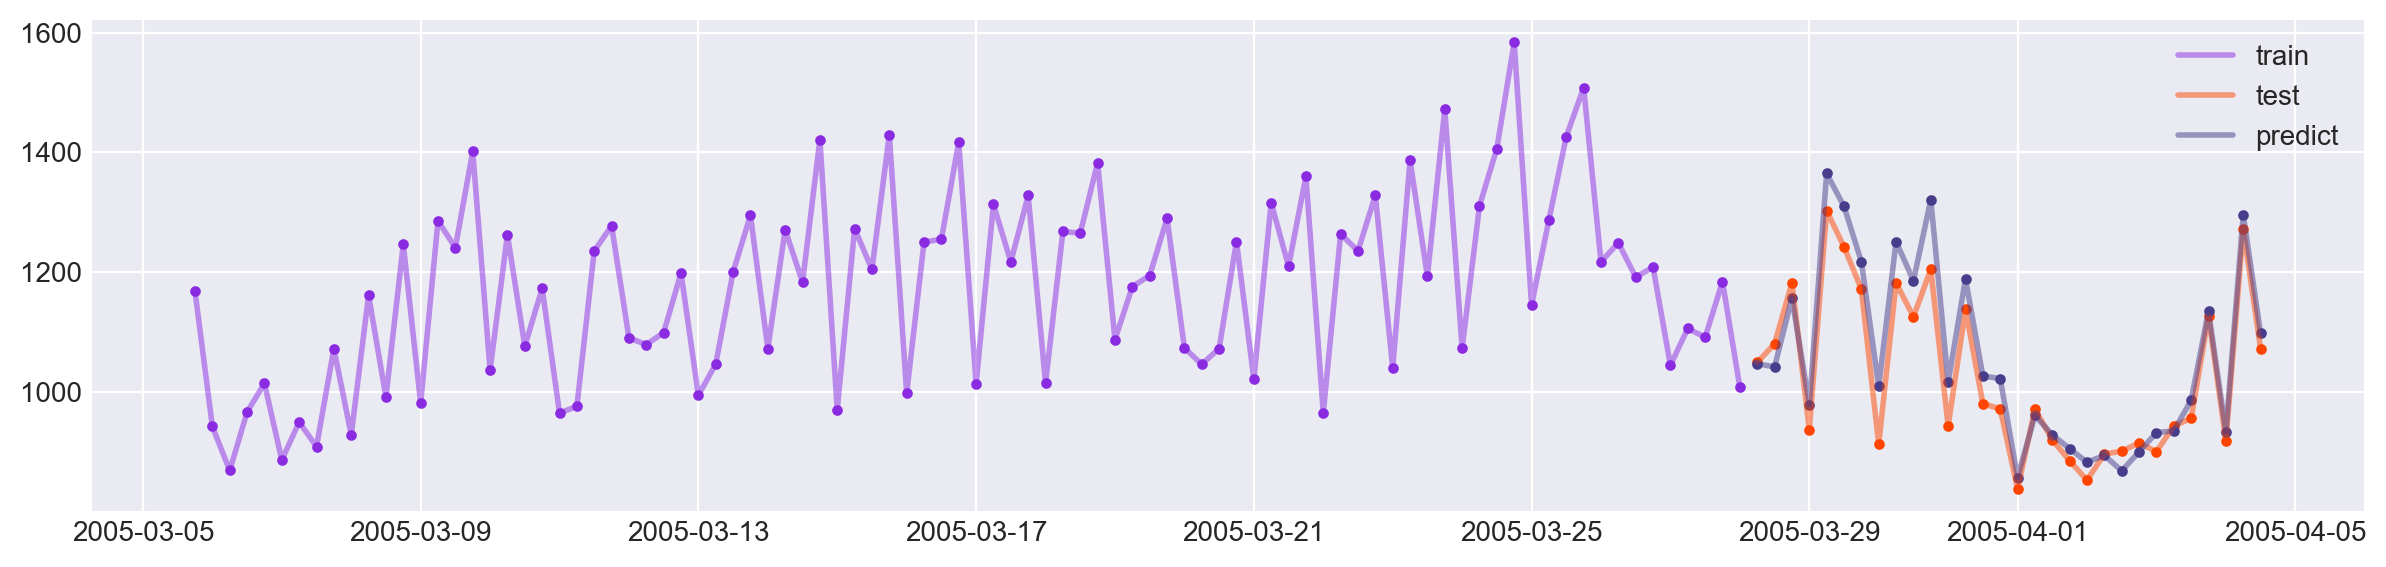

In [26]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [27]:
print(grid_search_results["params"])

{'l2_leaf_reg': 5}


In [28]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Prep For LSTM

In [29]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

dataframe shape (1560, 13)
dataframe shape after Feature Union (1557, 32)

data_x shape after seperate_target (1557, 31)
data_y shape after seperate_target (1557, 1)

data_x shape after StandardScaler (1557, 31)
data_y shape after StandardScaler (1557, 1)

x_window shape after Windowing (1534, 24, 31)
y_window shape after Windowing (1534, 1)

x_train_data shape after Test Train Split (1504, 24, 31)
x_test_data  shape after Test Train Split (30, 24, 31)
y_train_data shape after Test Train Split (1504, 1)
y_test_data  shape after Test Train Split (30, 1)



In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/25
200/200 [==============================] - 7s 23ms/step - loss: 0.2295 - mae: 0.3260 - val_loss: 0.1390 - val_mae: 0.3198
Epoch 2/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0667 - mae: 0.2015 - val_loss: 0.0145 - val_mae: 0.0949
Epoch 3/25
200/200 [==============================] - 5s 25ms/step - loss: 0.0191 - mae: 0.1081 - val_loss: 0.0090 - val_mae: 0.0786
Epoch 4/25
200/200 [==============================] - 4s 22ms/step - loss: 0.0326 - mae: 0.1390 - val_loss: 0.0103 - val_mae: 0.0764
Epoch 5/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0158 - mae: 0.0962 - val_loss: 0.0105 - val_mae: 0.0845
Epoch 6/25
200/200 [==============================] - 6s 29ms/step - loss: 0.0197 - mae: 0.1082 - val_loss: 0.0086 - val_mae: 0.0767
Epoch 7/25
200/200 [==============================] - 5s 26ms/step - loss: 0.0181 - mae: 0.1047 - val_loss: 0.0163 - val_mae: 0.1047
Epoch 8/25
200/200 [==============================] - 4s 21ms/step - 

In [31]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

yhat_scaled shape (30, 1) (30, 1)


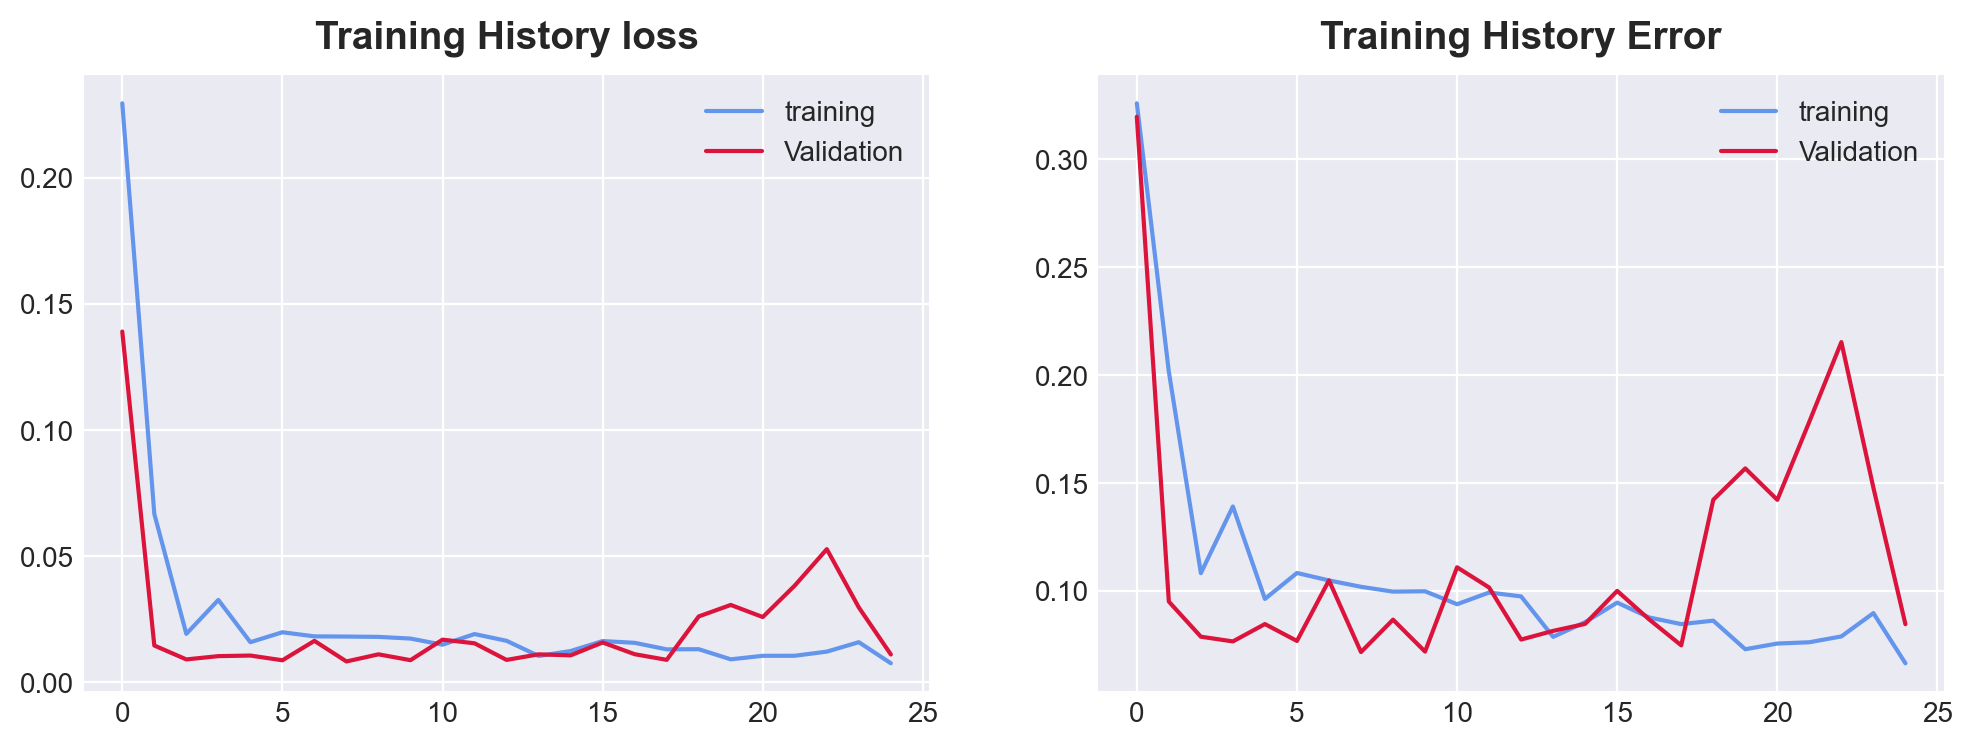

In [32]:
plot_tf_training_history(training_history)

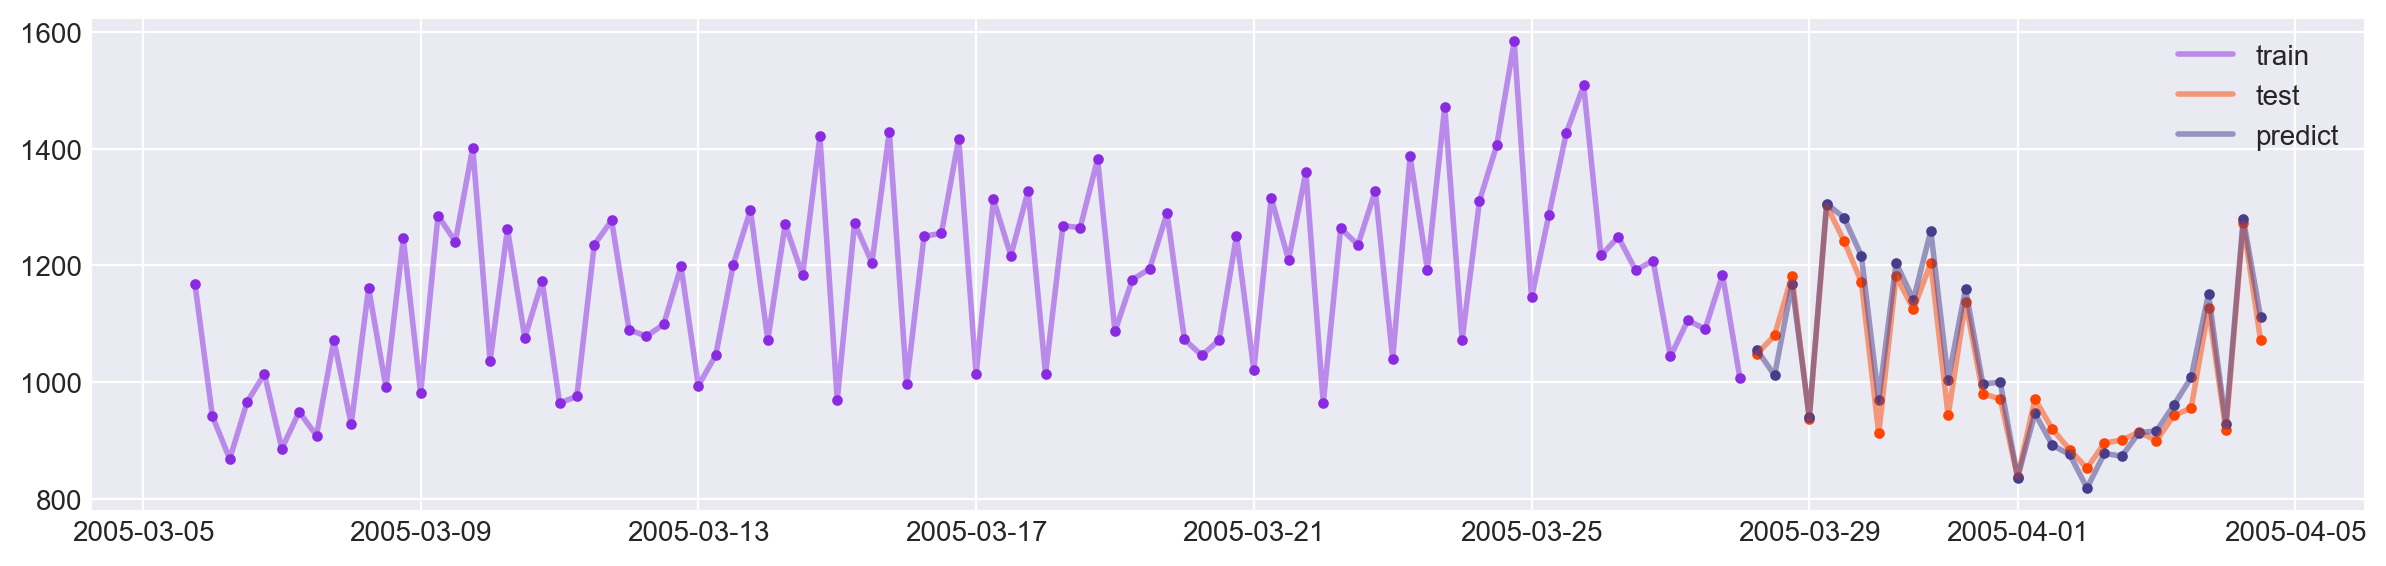

In [33]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [34]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,84.282222,34.531201,46.725282,30.877724,28.987366,40.930818,37.580054,25.671927
rmse,99.107293,41.079853,54.789204,36.605701,35.122370,49.502985,46.549659,31.771799
mape,0.084744,0.033769,0.047202,0.030088,0.028497,0.039494,0.035959,0.025183
r2,0.455497,0.906449,0.833590,0.925717,0.931616,0.864152,0.879878,0.944041


In [35]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,84.282222,99.107293,0.084744,0.455497
BayesianRidge,34.531201,41.079853,0.033769,0.906449
LassoCV,46.725282,54.789204,0.047202,0.833590
RandomForestRegressor,30.877724,36.605701,0.030088,0.925717
XGBRegressor,28.987366,35.122370,0.028497,0.931616
LGBMRegressor,40.930818,49.502985,0.039494,0.864152
CatBoostRegressor,37.580054,46.549659,0.035959,0.879878
LSTM_Dense,25.671927,31.771799,0.025183,0.944041


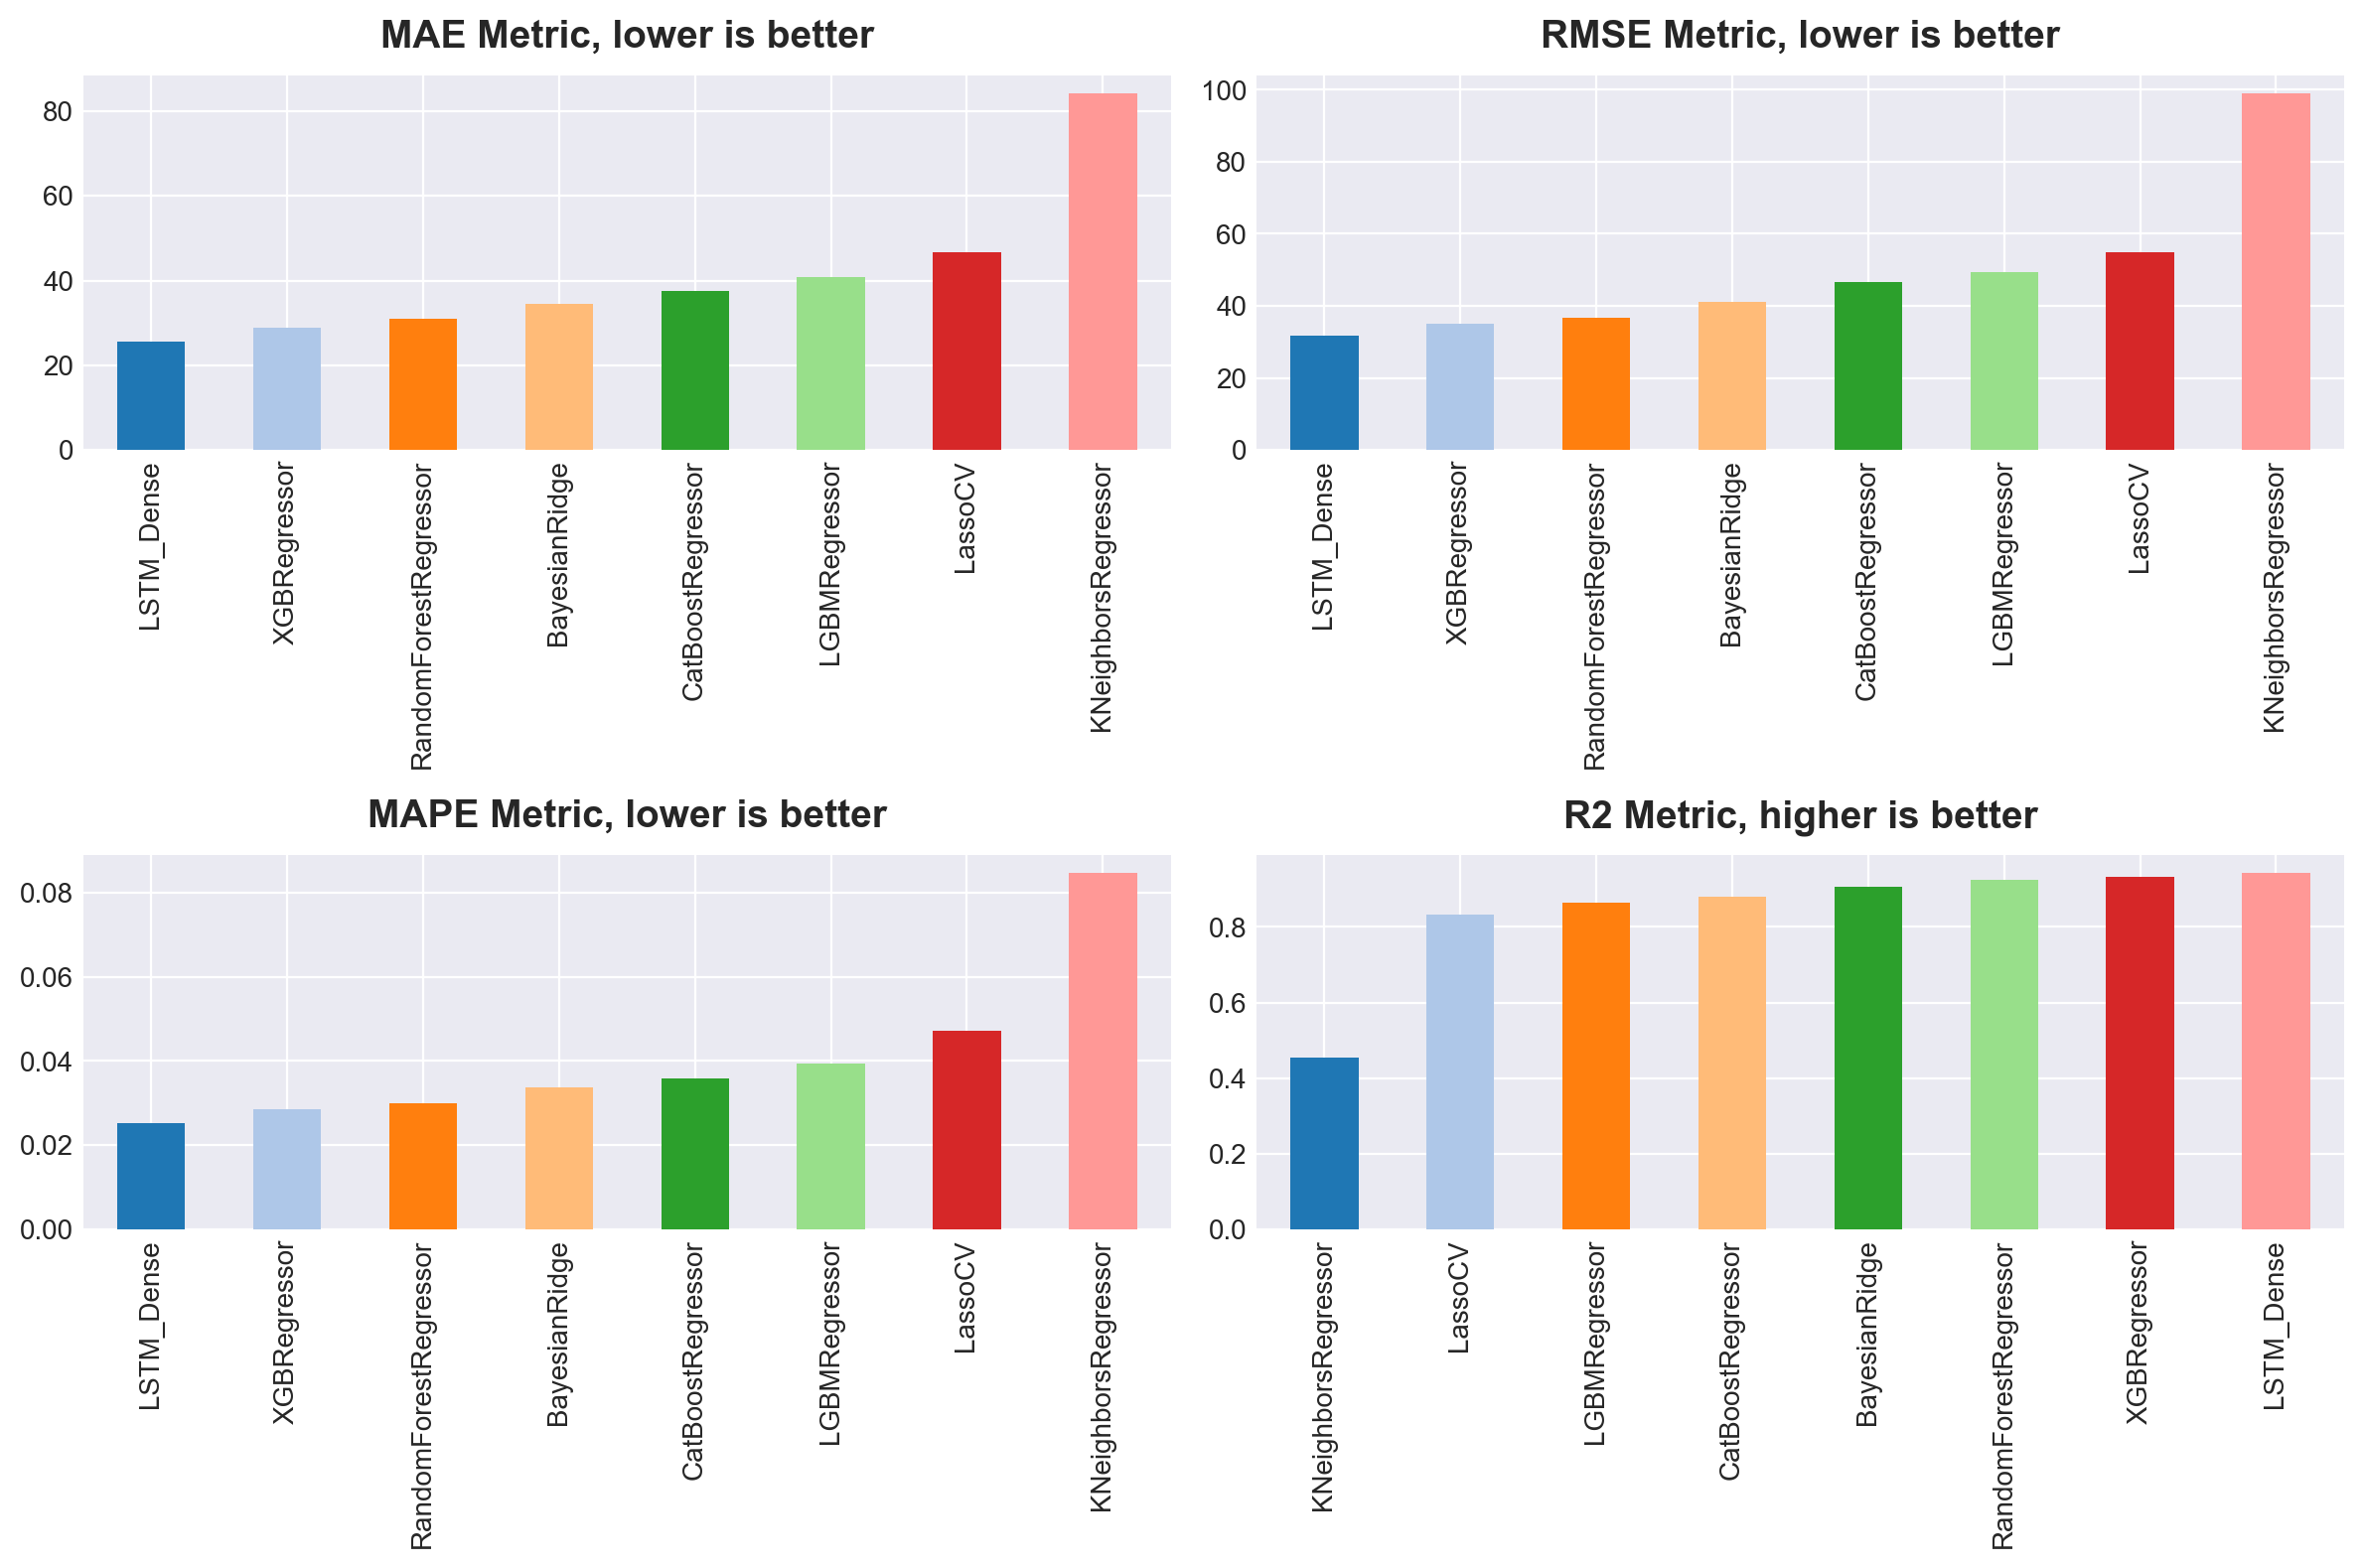

In [36]:
plot_metrics(resultsDF)

In [37]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Air_Quality"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)